# Estimating archaic TMRCAs from the real data

In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.0
✔ tibble  2.1.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Loading required package: future
Loading ychr
Warning message:
“no function found corresponding to methods exports from ‘GenomicRanges’ for: ‘concatenateObjects’”

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.975)

In [4]:
tafr <- calculate_tafr(highcov_gt)

In [5]:
tafr %>% filter(afr == "a00") %>% group_by(afr) %>% summarise_if(is.numeric, mean)

afr tmrca_afr tmrca_ad tmrca_f  mut_rate     age  
1 a00 265532.1  286552.9 244511.3 7.122598e-10 45000

In [8]:
tmrca_df <-
    map_dfr(c("den8", "den4", "mez2", "spy1", "shotgun_den8", "shotgun_mez2", "shotgun_spy1"), function(arch) {
    map_dfr(c("all", "tv_only"), function(sites) {
        read_genotypes(arch, "full", mindp = 3, tv_only = sites == "tv_only") %>%
            calculate_tarch(tafr) %>%
            mutate(sites = sites)
    })
})

In [13]:
tmrca_df %>% filter(afr == "a00") %>% unnest(counts_arch) %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch         tmrca_arch alpha    tmrca_afr tmrca_ad tmrca_f  mut_rate    
1 den4         614276.6   2.511341 265532.1  286552.9 244511.3 7.122598e-10
2 den8         642380.8   2.627071 265532.1  286552.9 244511.3 7.122598e-10
3 mez2         361980.4   1.480306 265532.1  286552.9 244511.3 7.122598e-10
4 shotgun_den8      NaN        NaN 265532.1  286552.9 244511.3 7.122598e-10
5 shotgun_mez2 387450.5   1.584362 265532.1  286552.9 244511.3 7.122598e-10
6 shotgun_spy1 357489.5   1.461264 265532.1  286552.9 244511.3 7.122598e-10
7 spy1         361790.9   1.479472 265532.1  286552.9 244511.3 7.122598e-10
  a          b         c           d         e          f         total    
1 213.615385  6.769231  4.38461538 108.03846 176.615385 300.42308 1358174.9
2 693.192308 20.500000 10.96153846 375.46154 477.461538 813.57692 3212641.9
3 290.230769 22.923077 17.03846154 584.92308 599.346154 714.26923 4445102.0
4   0.000000  0.000000  0.00000000   0.00000   0.000000   0.00000       0.0
5  26.269231  4.423077  2.88461538  44.92308  47.307692  79.19231  364363.8
6   4.230769  0.000000  0.07692308  11.23077   6.769231  26.76923  102956.7
7  25.653846  6.000000  0.34615385  46.69231  57.346154 350.34615  495934.2

Can I use the ratio of shotgun-vs-capture TMRCA's to get an idea about a reference bias?

In [4]:
tafr %>% filter(afr == "a00") %>% group_by(afr) %>% summarise_if(is.numeric, mean)

afr tmrca_afr tmrca_ad tmrca_f  mut_rate     age  
1 a00 265532.1  286552.9 244511.3 7.122598e-10 45000

In [5]:
tmrca_full %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "full", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [6]:
tmrca_lippold %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1", "elsidron2"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "lippold", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [7]:
tmrca_exome %<-%
    map_dfr(c("den8", "den4", "mez2", "spy1", "elsidron1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "exome", mindp = dp, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [8]:
tmrca_full %<>% mutate(capture = "full")
tmrca_lippold %<>% mutate(capture = "lippold")
tmrca_exome %<>% mutate(capture = "exome")

In [9]:
tmrca_df <- bind_rows(tmrca_full, tmrca_lippold, tmrca_exome)

In [10]:
saveRDS(tmrca_df, here("data/rds/tmrca2.rds"))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


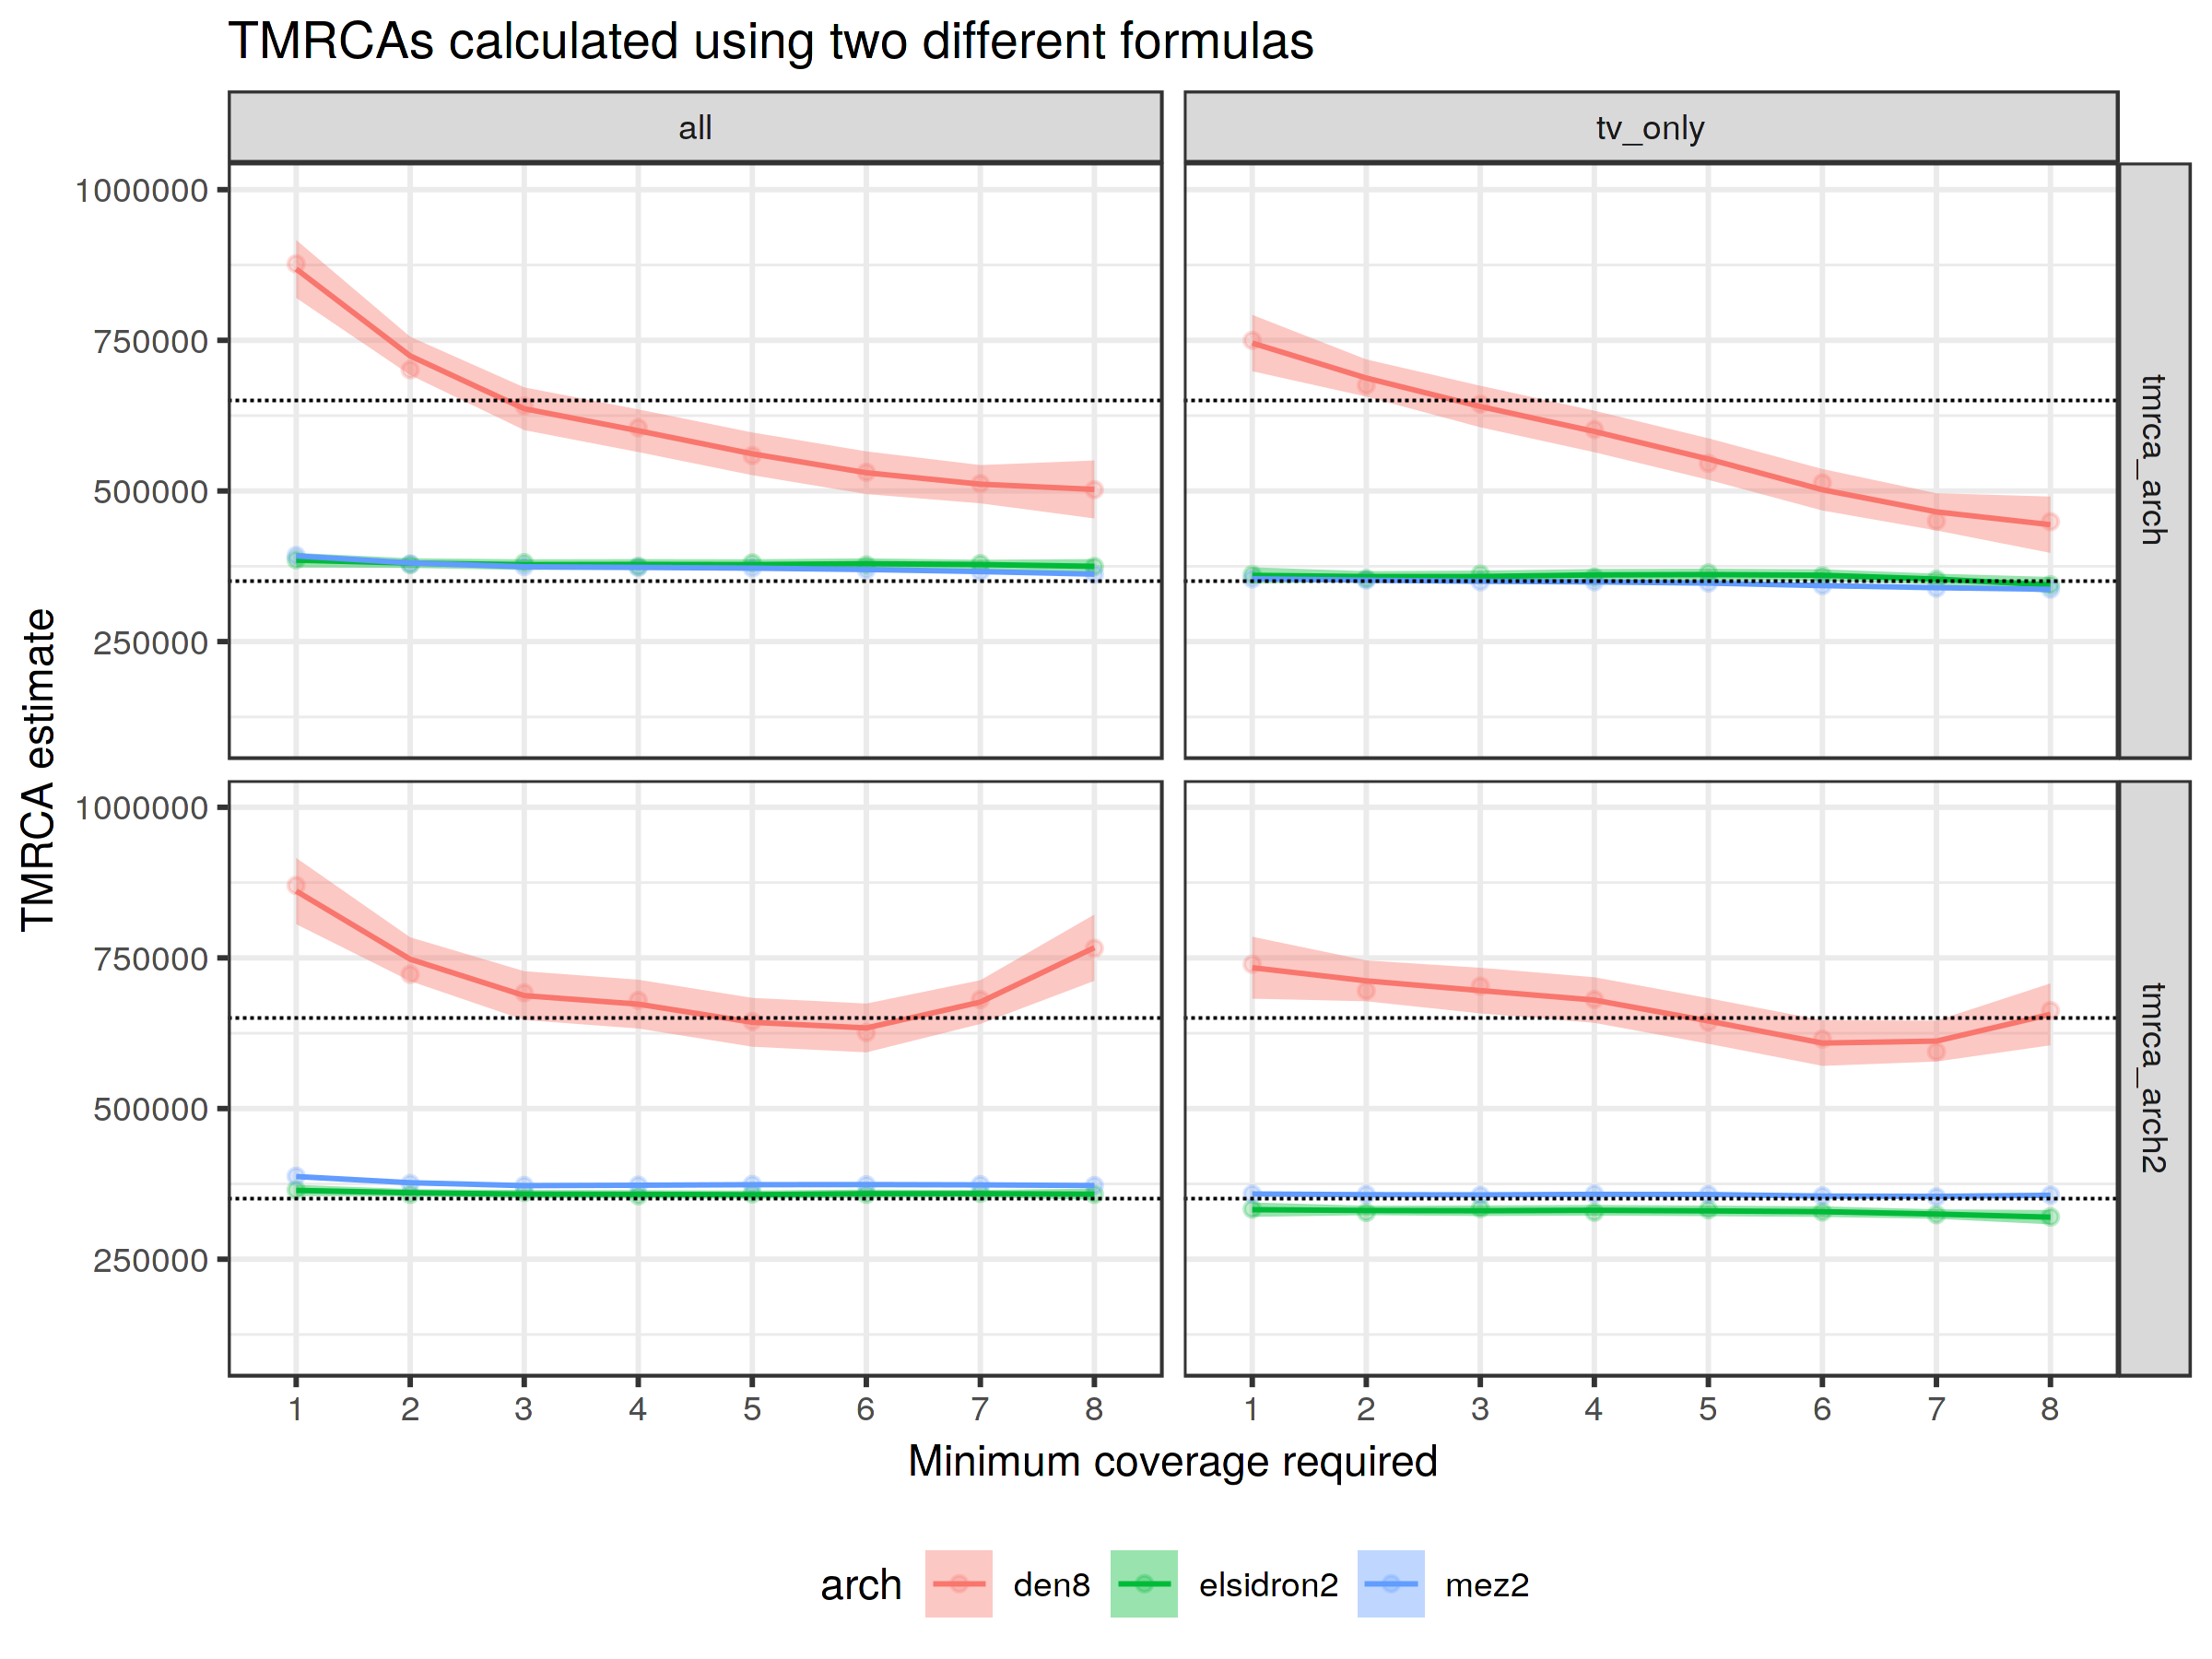

In [12]:
set_dim(8, 6)

tmrca_df %>%
filter(afr == "a00", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2") %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(100000, 1000000)) +
    facet_grid(tmrca ~ sites) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

# Why do `d` and `e` counts differ so much depending on coverage?

# How does that depend on a chosen African?

In [13]:
set_dim(6, 3)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00") %>%
filter(capture == "full" & arch %in% c("den8"), sites == "all") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>% select(-starts_with("tmrca"), -mut_rate) %>%
group_by(arch, afr, dp) %>%
summarise_if(is.numeric, mean) %>%
arrange(dp) %>%
mutate(d_a = d / a, e_a = e / a, d_e = d / e)

arch afr dp alpha    a          b          c         d         e        
1 den8 a00 1  3.585851 2193.38462 55.2307692 23.769231 857.53846 839.00000
2 den8 a00 2  2.866927 1274.53846 41.9230769 18.923077 652.15385 713.38462
3 den8 a00 3  2.620671  826.76923 32.2307692 13.461538 452.23077 568.23077
4 den8 a00 4  2.473522  510.92308 21.6153846 10.384615 287.61538 406.07692
5 den8 a00 5  2.285260  282.92308  7.8461538  8.692308 173.15385 267.30769
6 den8 a00 6  2.171504  154.15385  3.8461538  2.307692  99.15385 164.23077
7 den8 a00 7  2.094767   78.07692  0.8461538  1.615385  44.23077  98.61538
8 den8 a00 8  2.053920   37.23077  0.0000000  1.230769  18.07692  52.76923
  f           total     n_muts     d_a       e_a       d_e      
1 20371.92308 4916308.0 24340.8462 0.3909658 0.3825139 1.0220959
2  2822.00000 4127493.1  5522.9231 0.5116784 0.5597200 0.9141686
3  1073.00000 3226978.8  2965.9231 0.5469855 0.6872907 0.7958576
4   607.61538 2342622.6  1844.2308 0.5629329 0.7947907 0.7082781
5   347.69231 1572713.2  1087.6154 0.6120174 0.9448070 0.6477698
6   198.07692  974623.4   621.7692 0.6432136 1.0653693 0.6037471
7    95.76923  549088.7   319.1538 0.5665025 1.2630542 0.4485179
8    45.69231  271434.3   155.0000 0.4855372 1.4173554 0.3425656

^^^ note that the `a` length is getting A LOT shorter as we increase the coverage cutoff

### Does the following mean that the `a` branch is getting increasingly shorter than `e` the higher the required coverage cutoff is?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


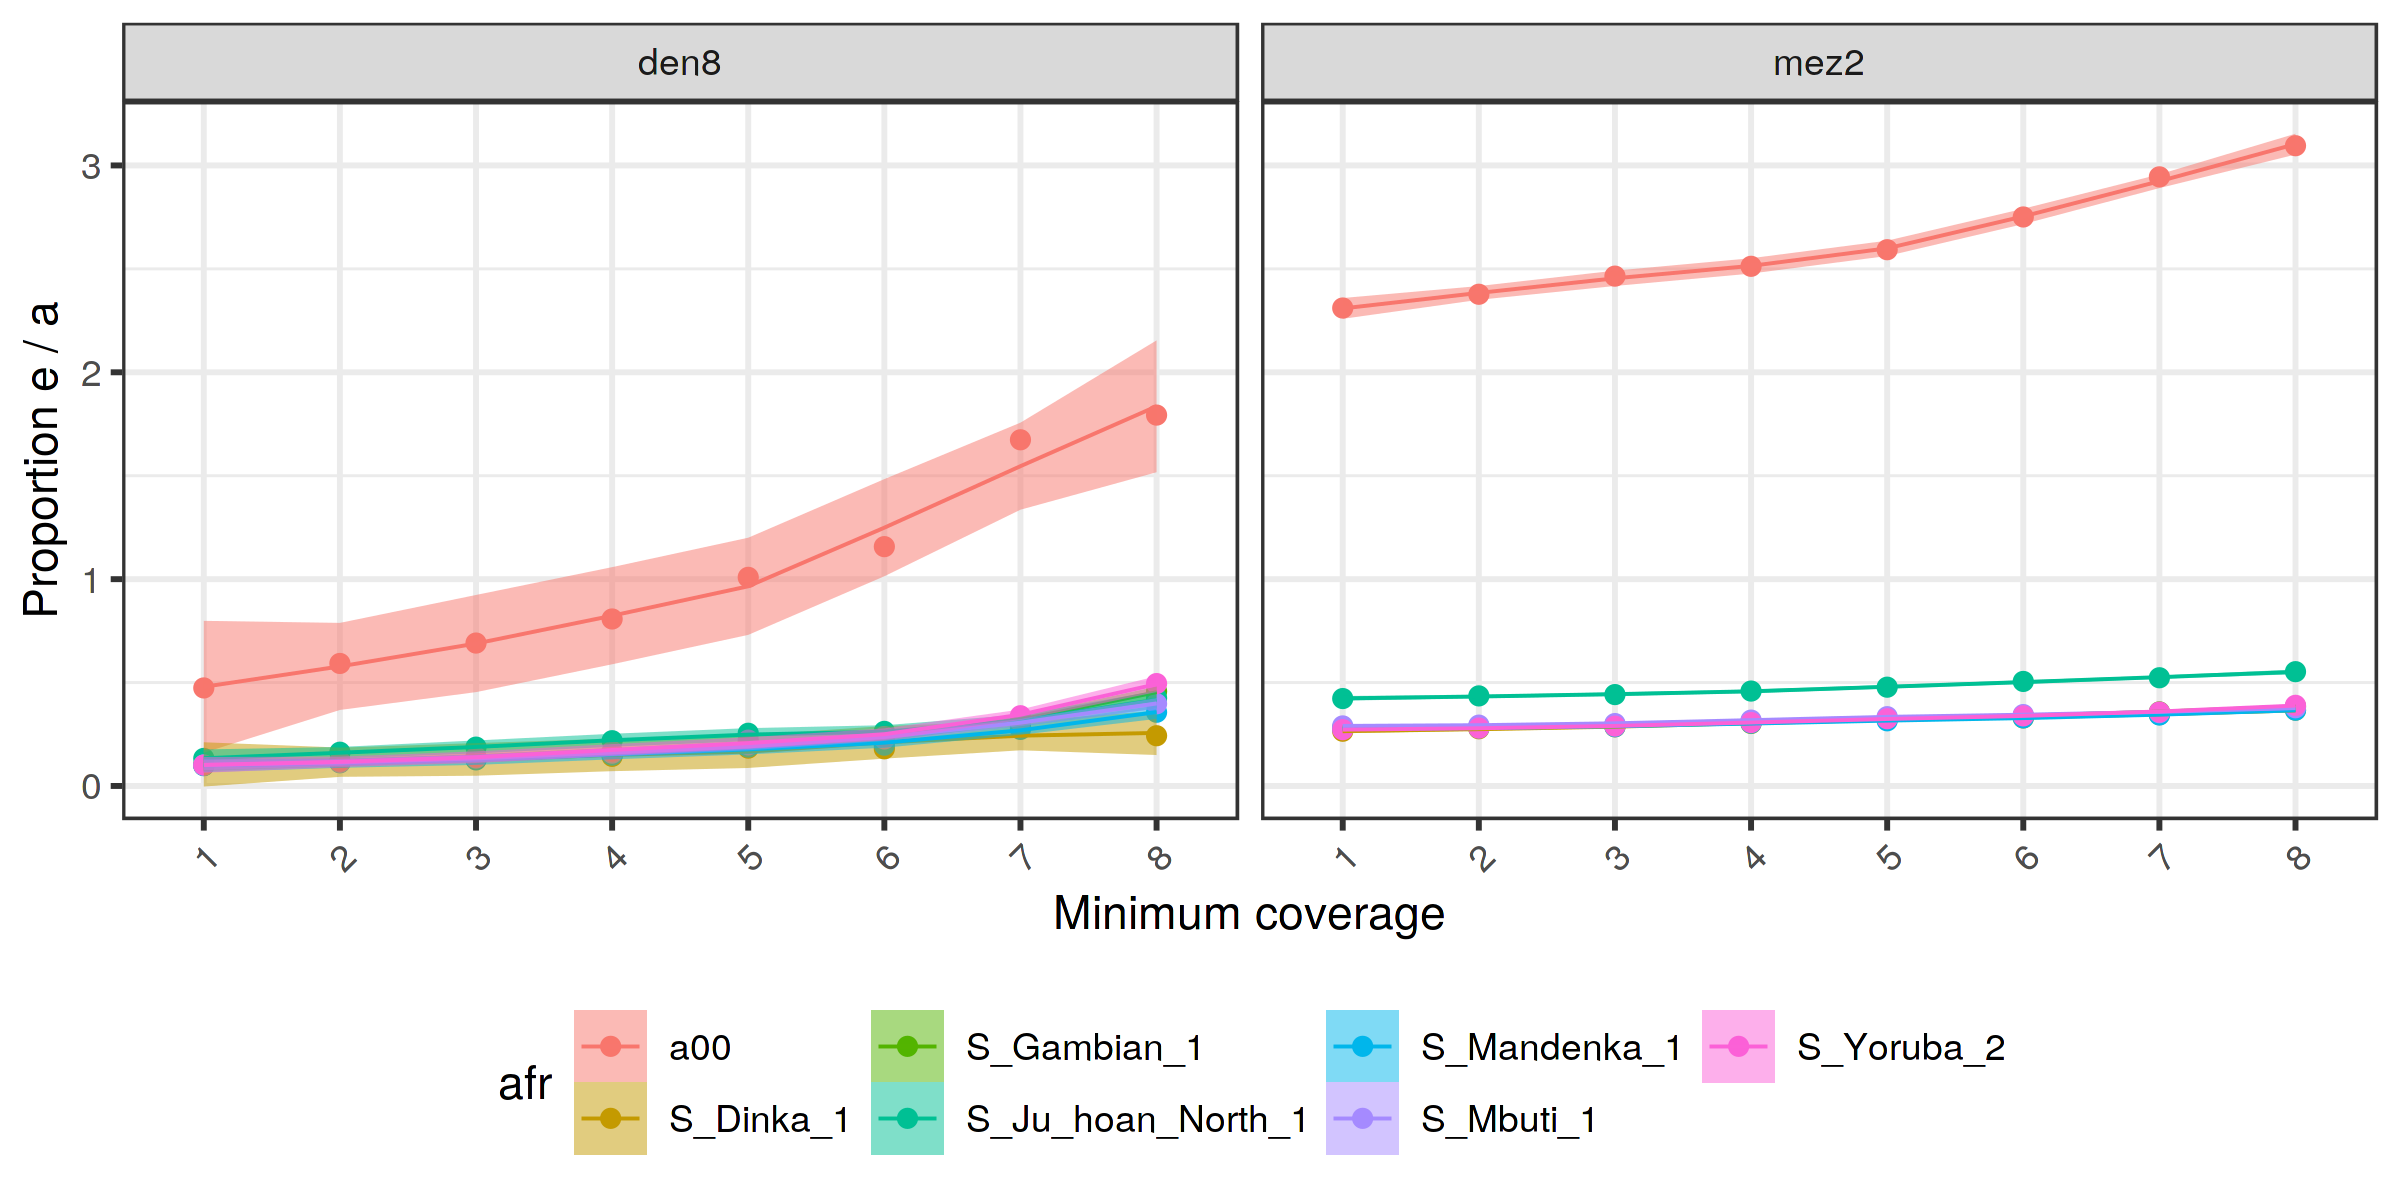

In [14]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(dp < 9, sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### ... but not the `d` branch... ?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


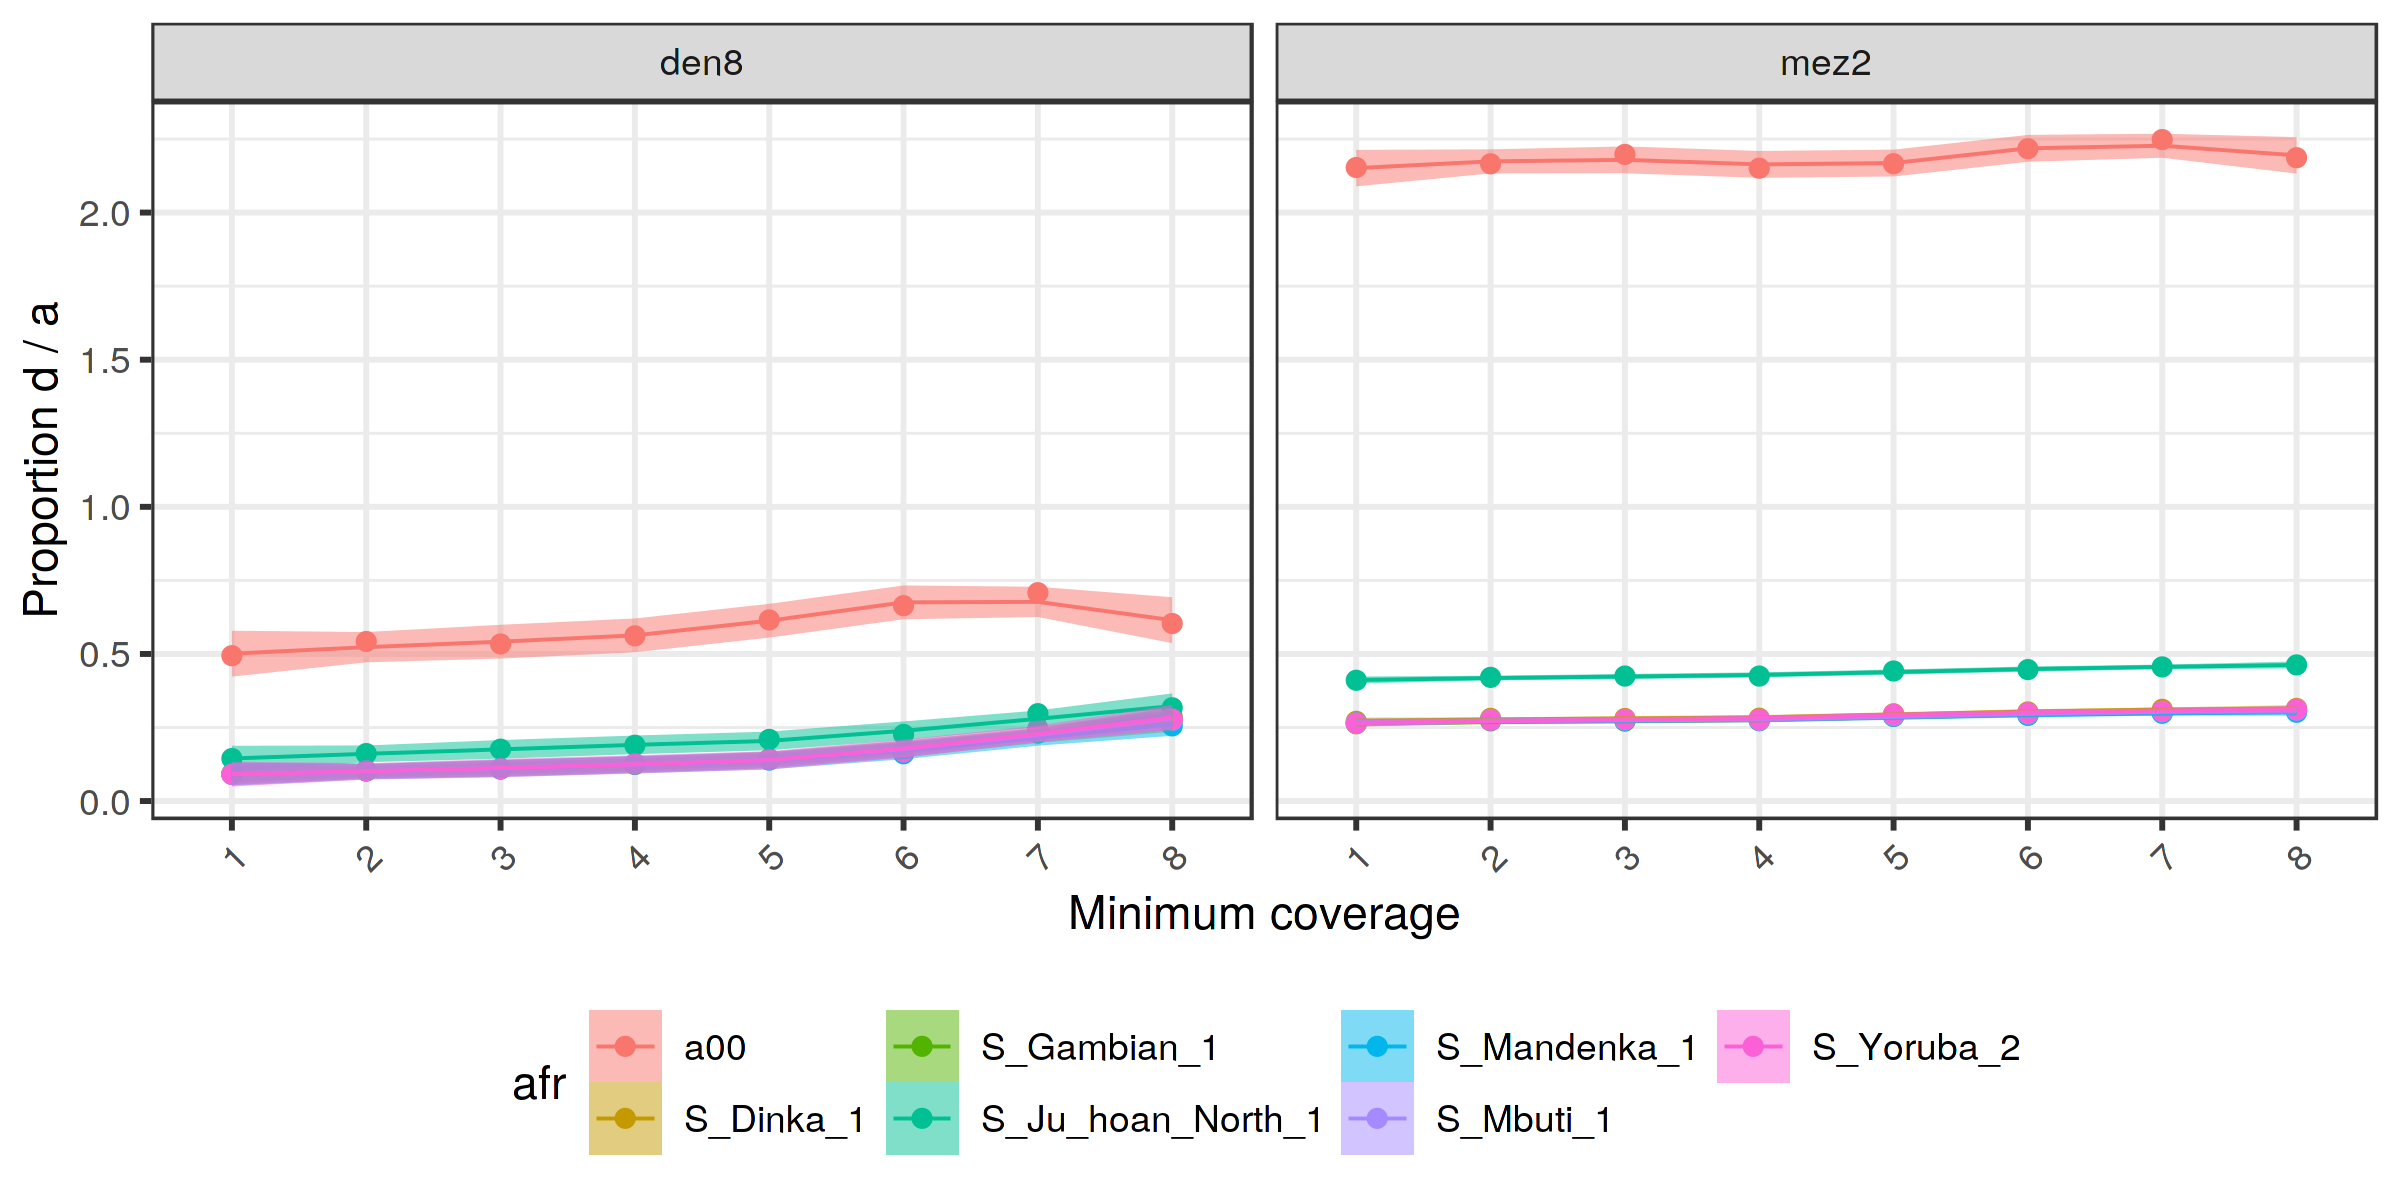

In [15]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(dp < 9, sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### A00 - both `a` and `d` relatively stable across coverage, but `e` is increasing

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


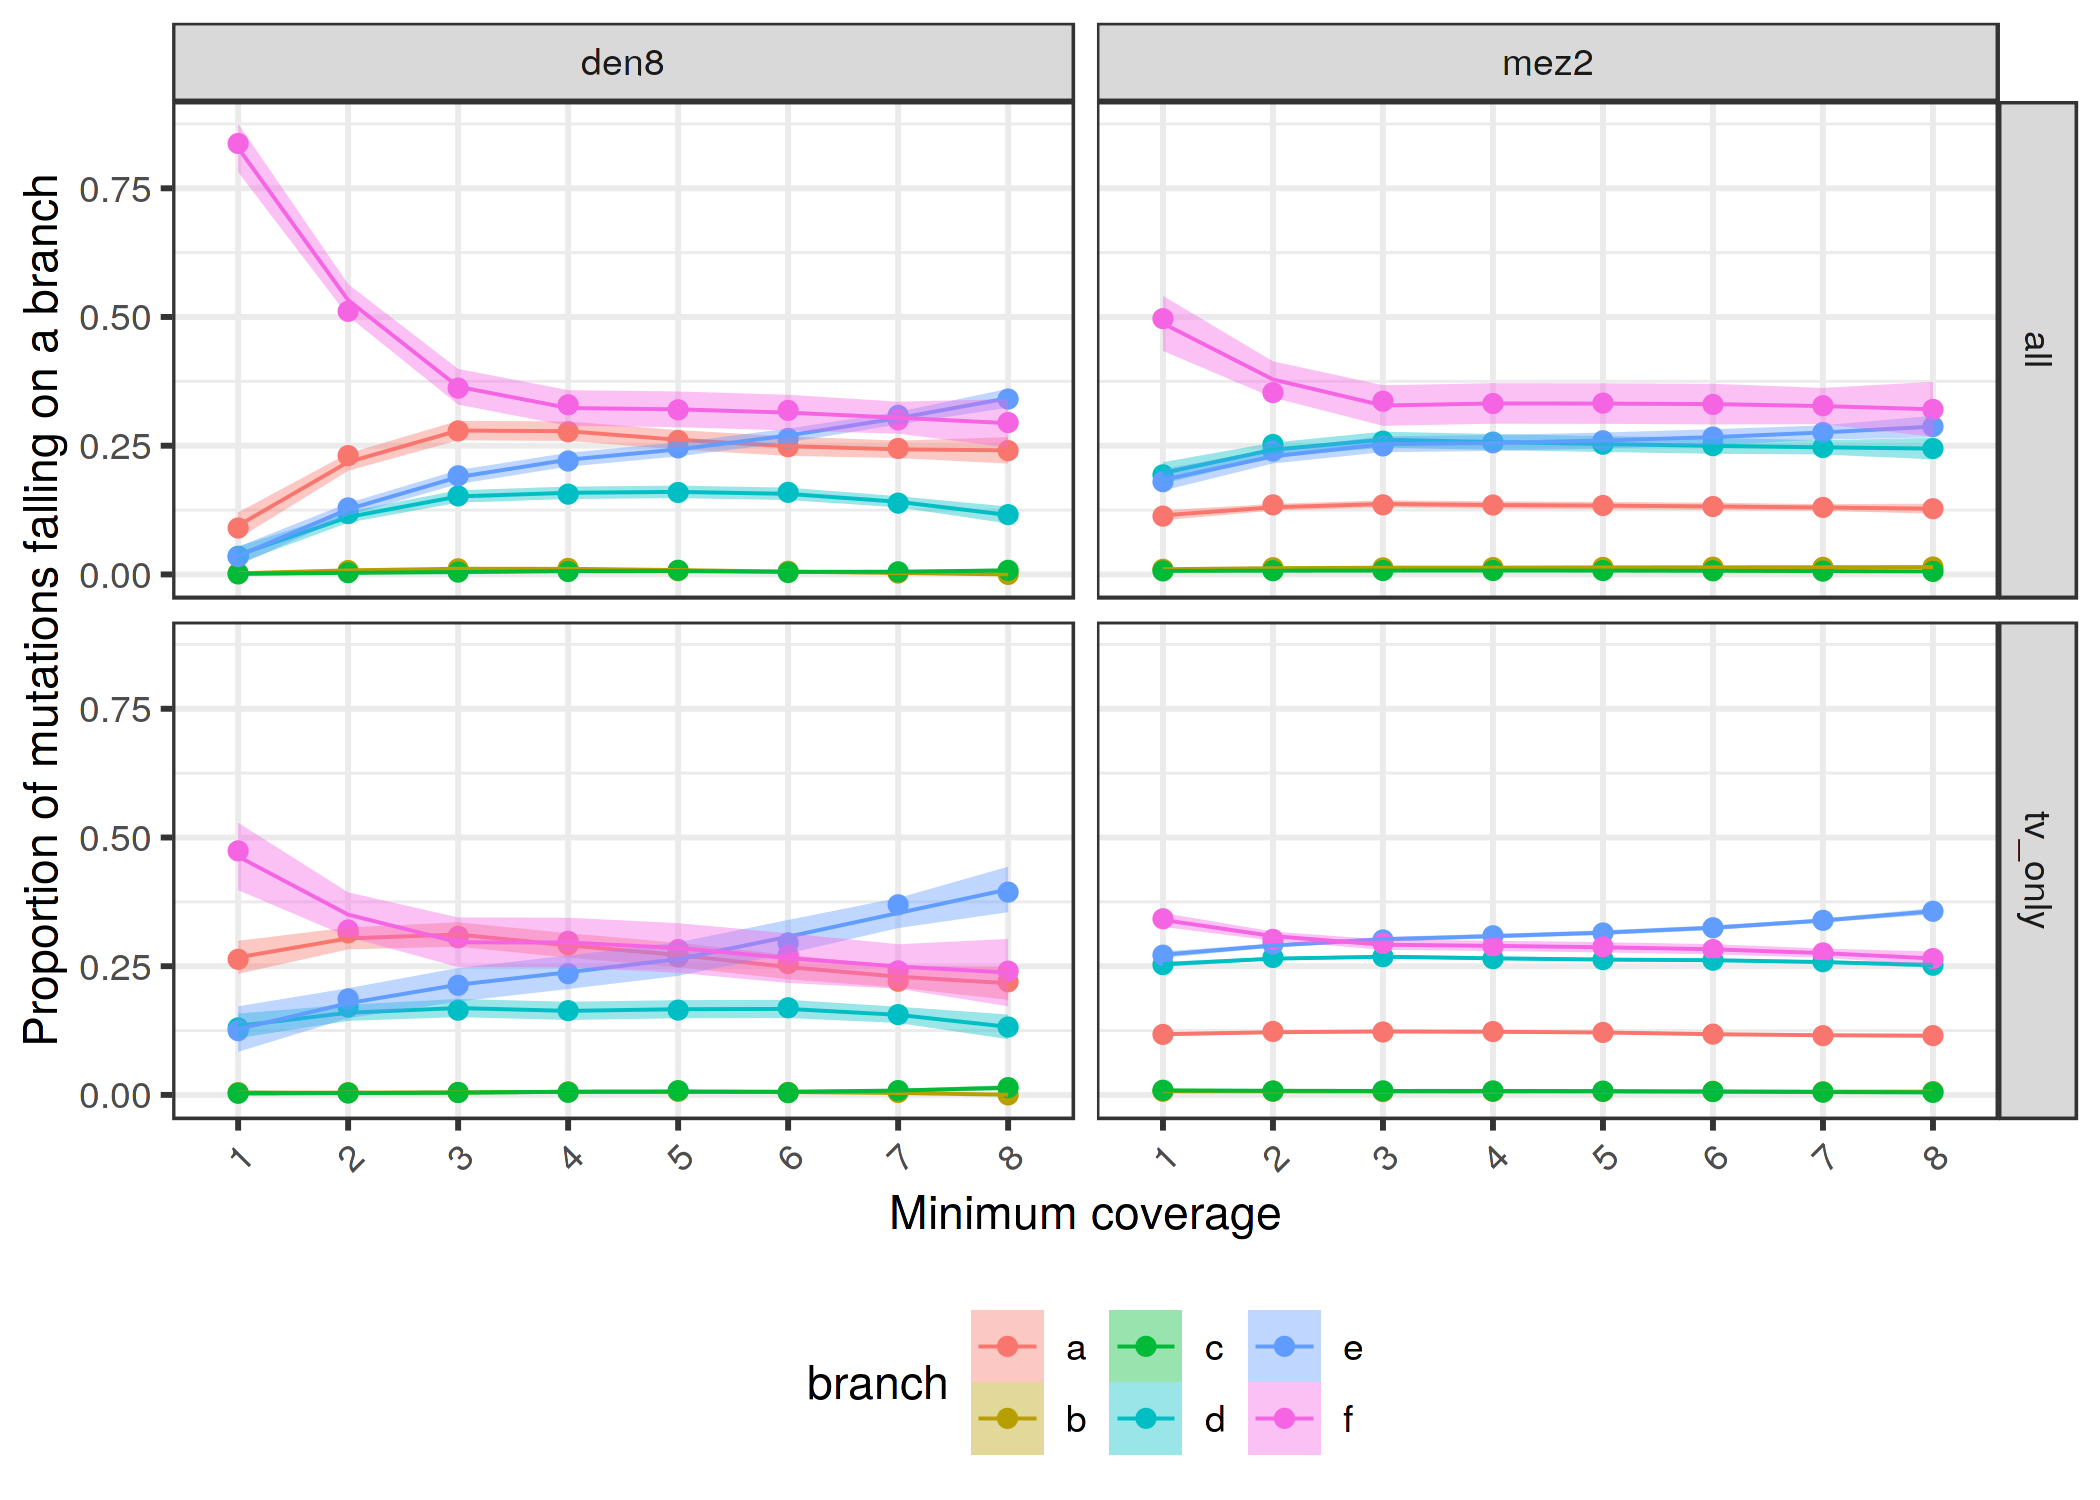

In [17]:
set_dim(7, 5)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>%
group_by(arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean) %>%
ggplot(aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_smooth(size = 1/3) +
    facet_grid(sites ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

^^^ `a` and `f` appear to level after `dp >= 3` which seems OK???

but `e` is increasing steadily - this is super weird and could be driving `a / (a + d + e)` higher at higher cutoffs?
* is the increased proportion of `e` branch the reference bias signal?


### other Africans -  `a` relatively stable across coverage, but both `d` and `e` are increasing

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


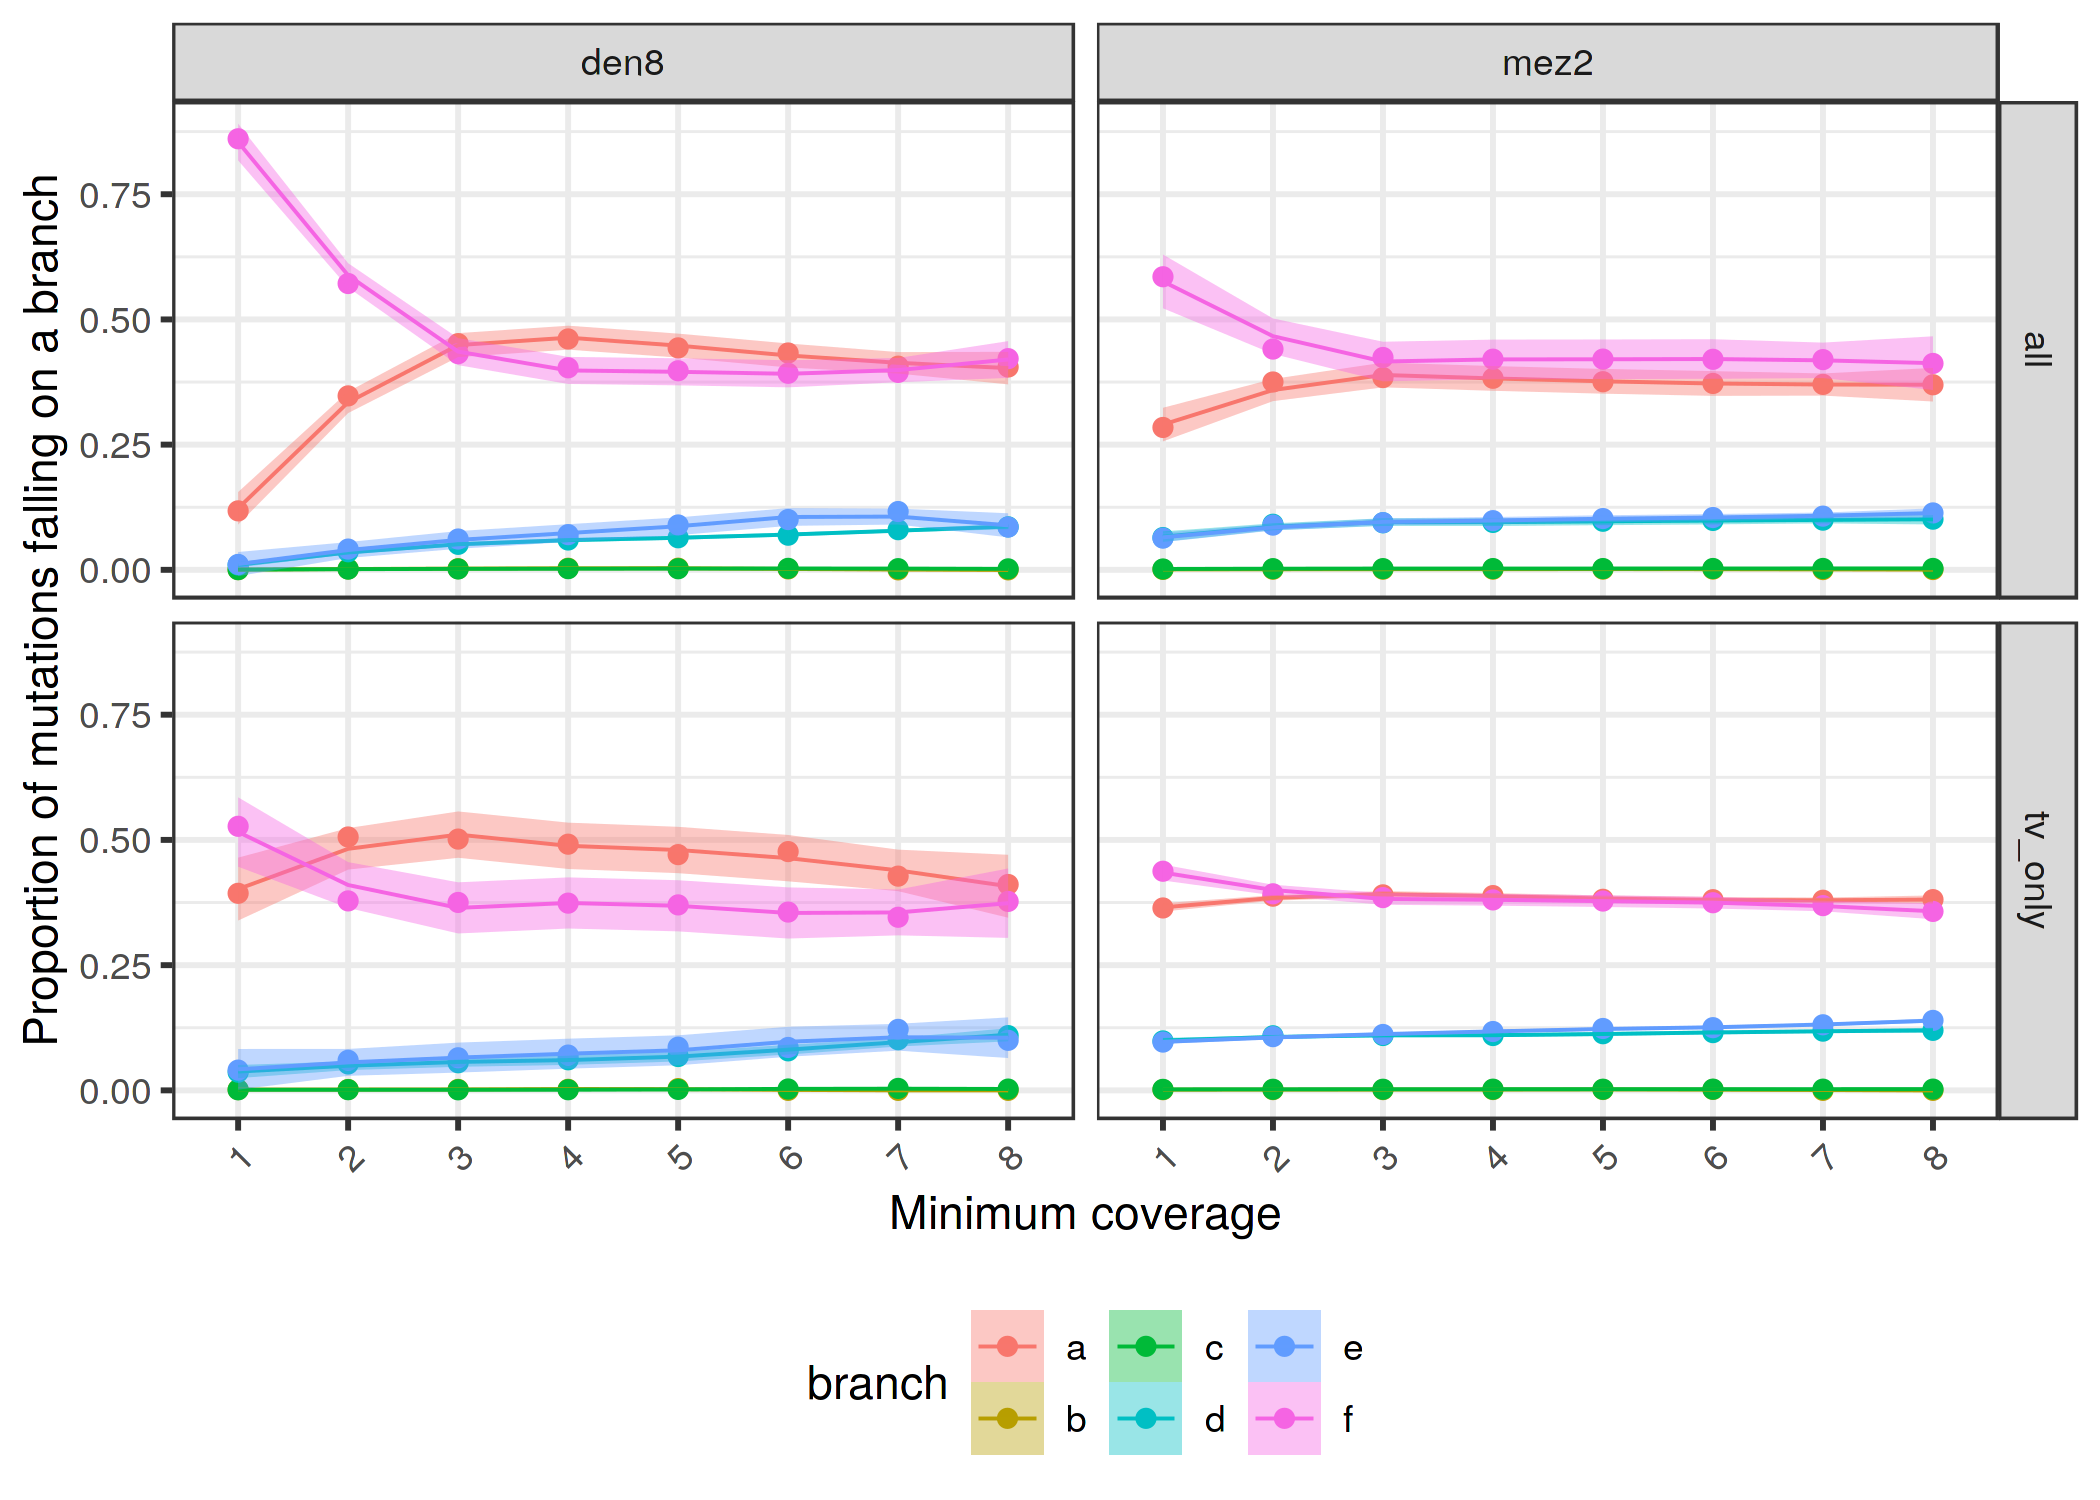

In [16]:
set_dim(7, 5)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "S_Dinka_1", dp < 9) %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>%
group_by(arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean) %>%
ggplot(aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_smooth(size = 1/3) +
    facet_grid(sites ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


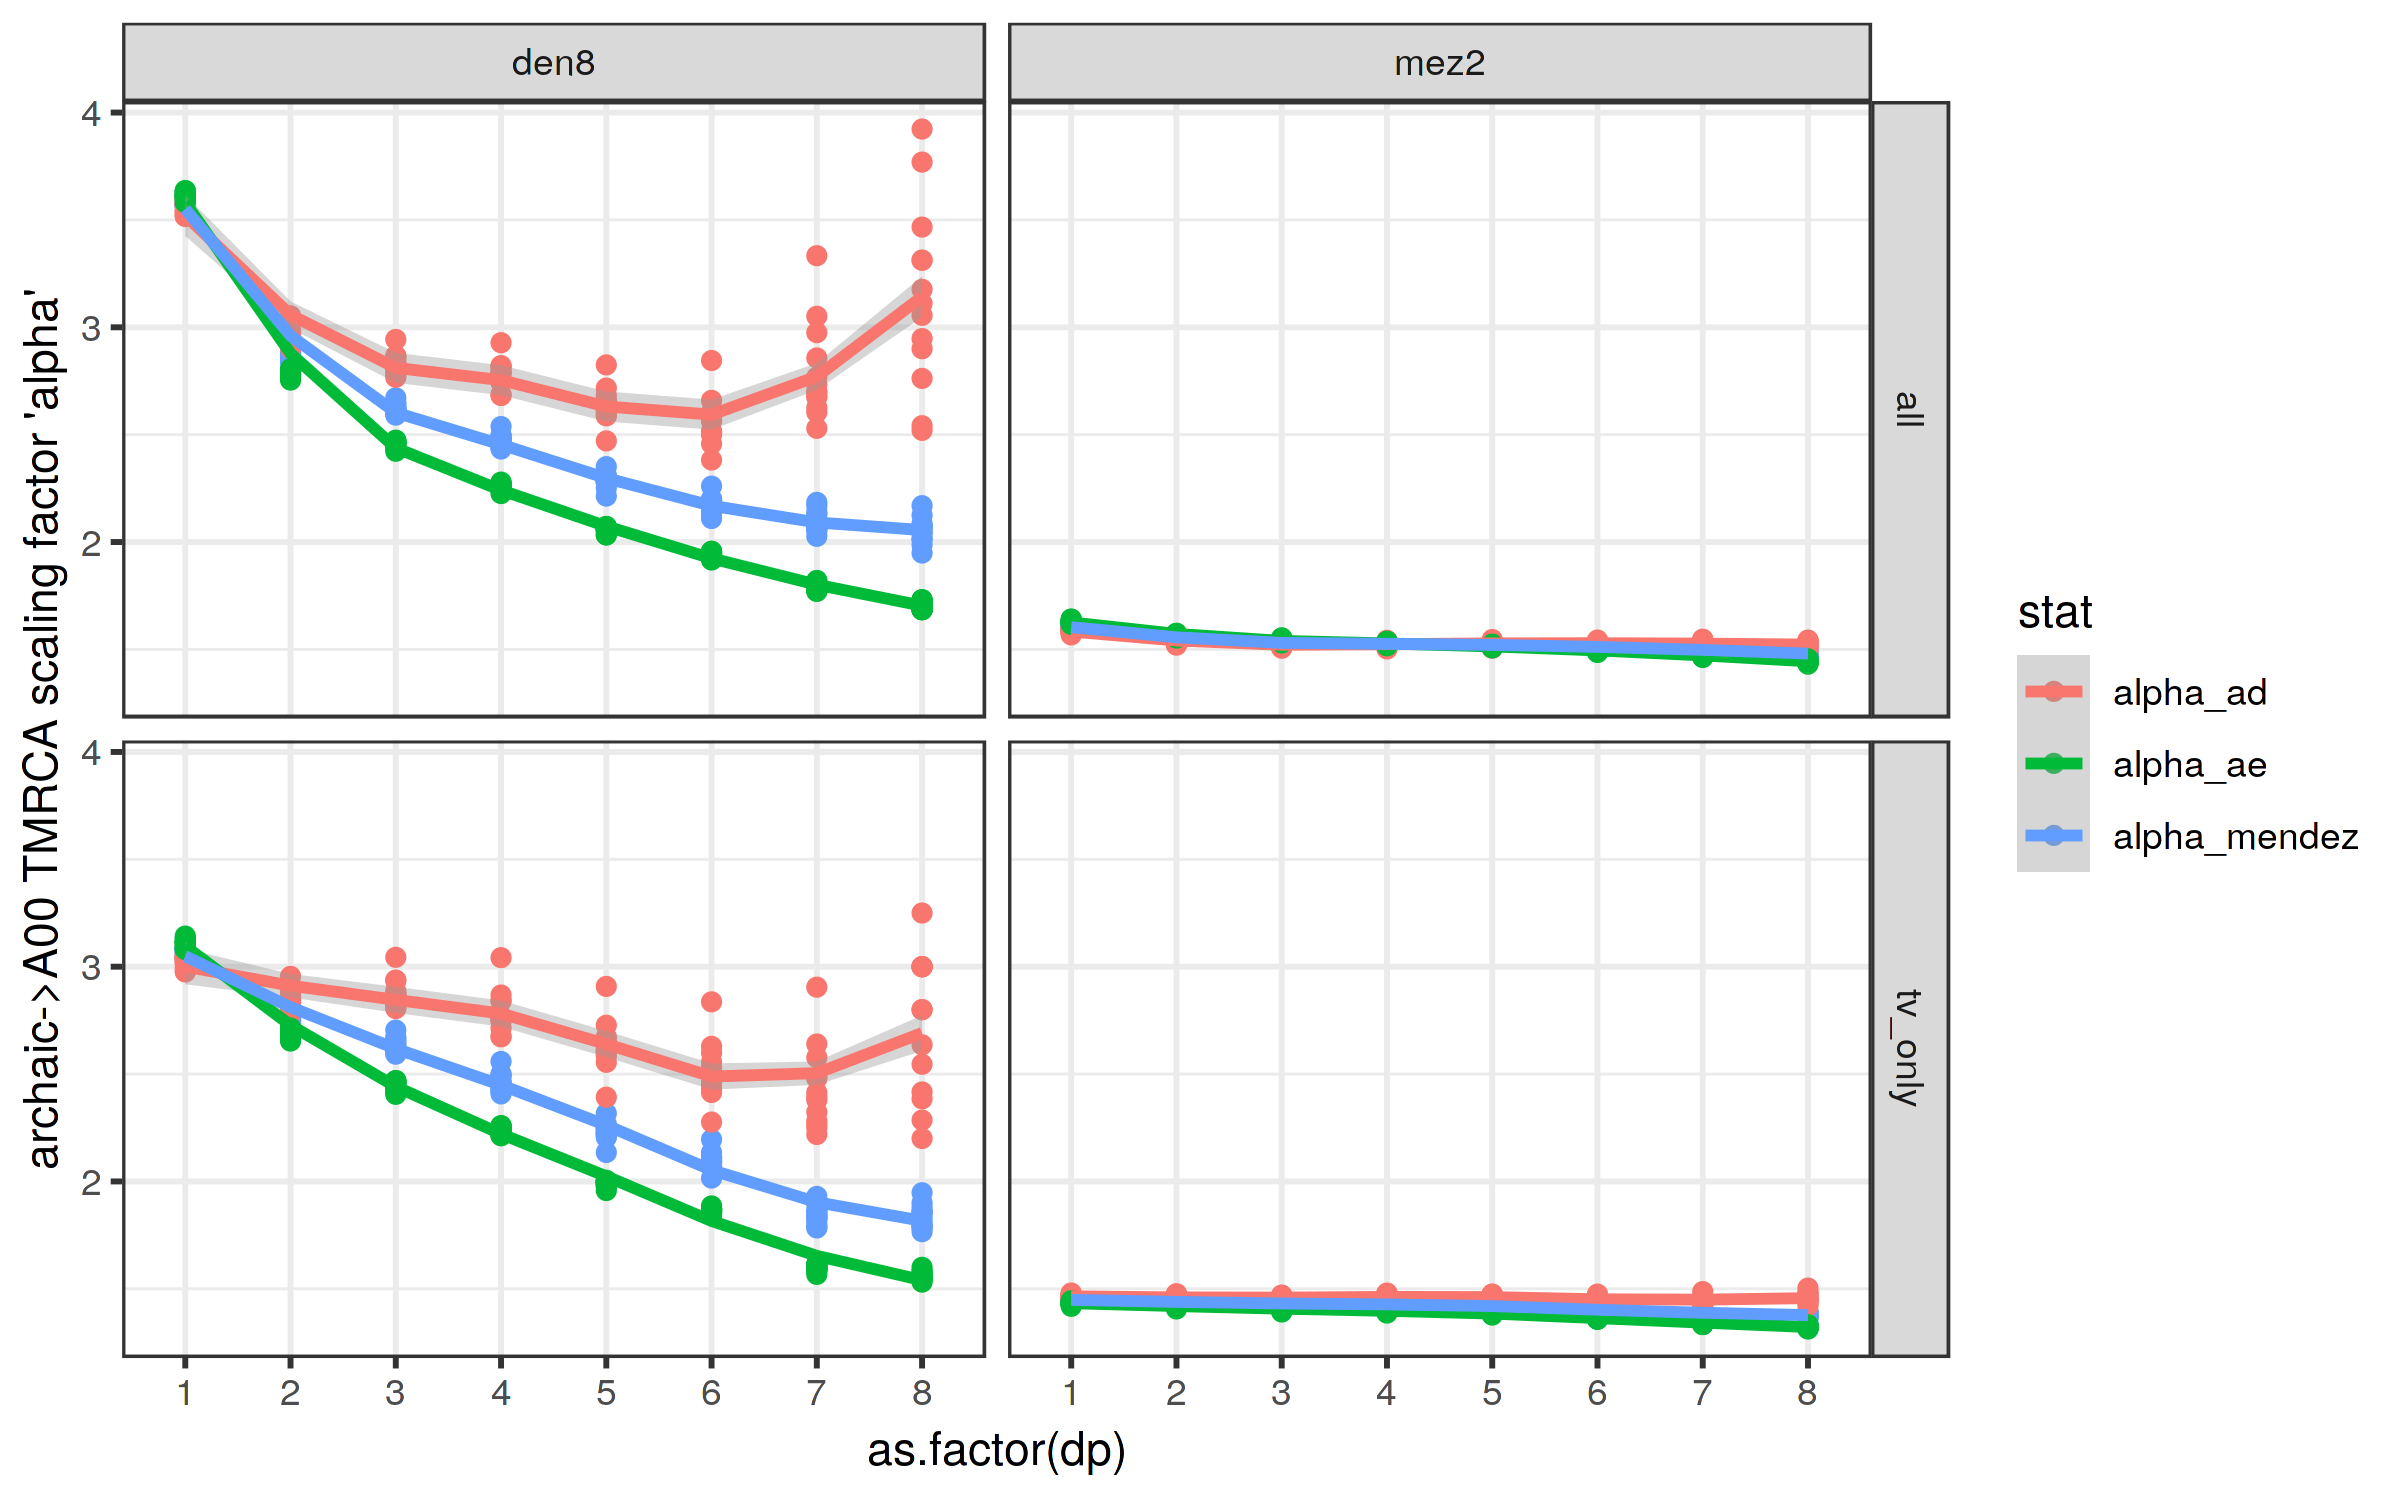

In [18]:
set_dim(8, 5)

tmrca_df %>%
filter(dp < 9, capture == "full", afr == "a00", arch %in% c("mez2", "den8")) %>% unnest(counts_arch) %>%
select(arch, dp, tmrca_arch, alpha_mendez = alpha, sites, tmrca_f, a, b, c, d, e, f) %>%
mutate(
    alpha_ad = (a + d) / d,
    alpha_ae = (a + e) / e
) %>%
select(arch, dp, sites, starts_with("alpha")) %>%
gather(stat, value, -arch, -dp, -sites) %>%
ggplot(aes(as.factor(dp), value, color = stat)) +
    geom_point() +
    geom_smooth(aes(group = stat)) +
    theme_bw() +
    facet_grid(sites ~ arch) +
    ylab("archaic->A00 TMRCA scaling factor 'alpha'")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


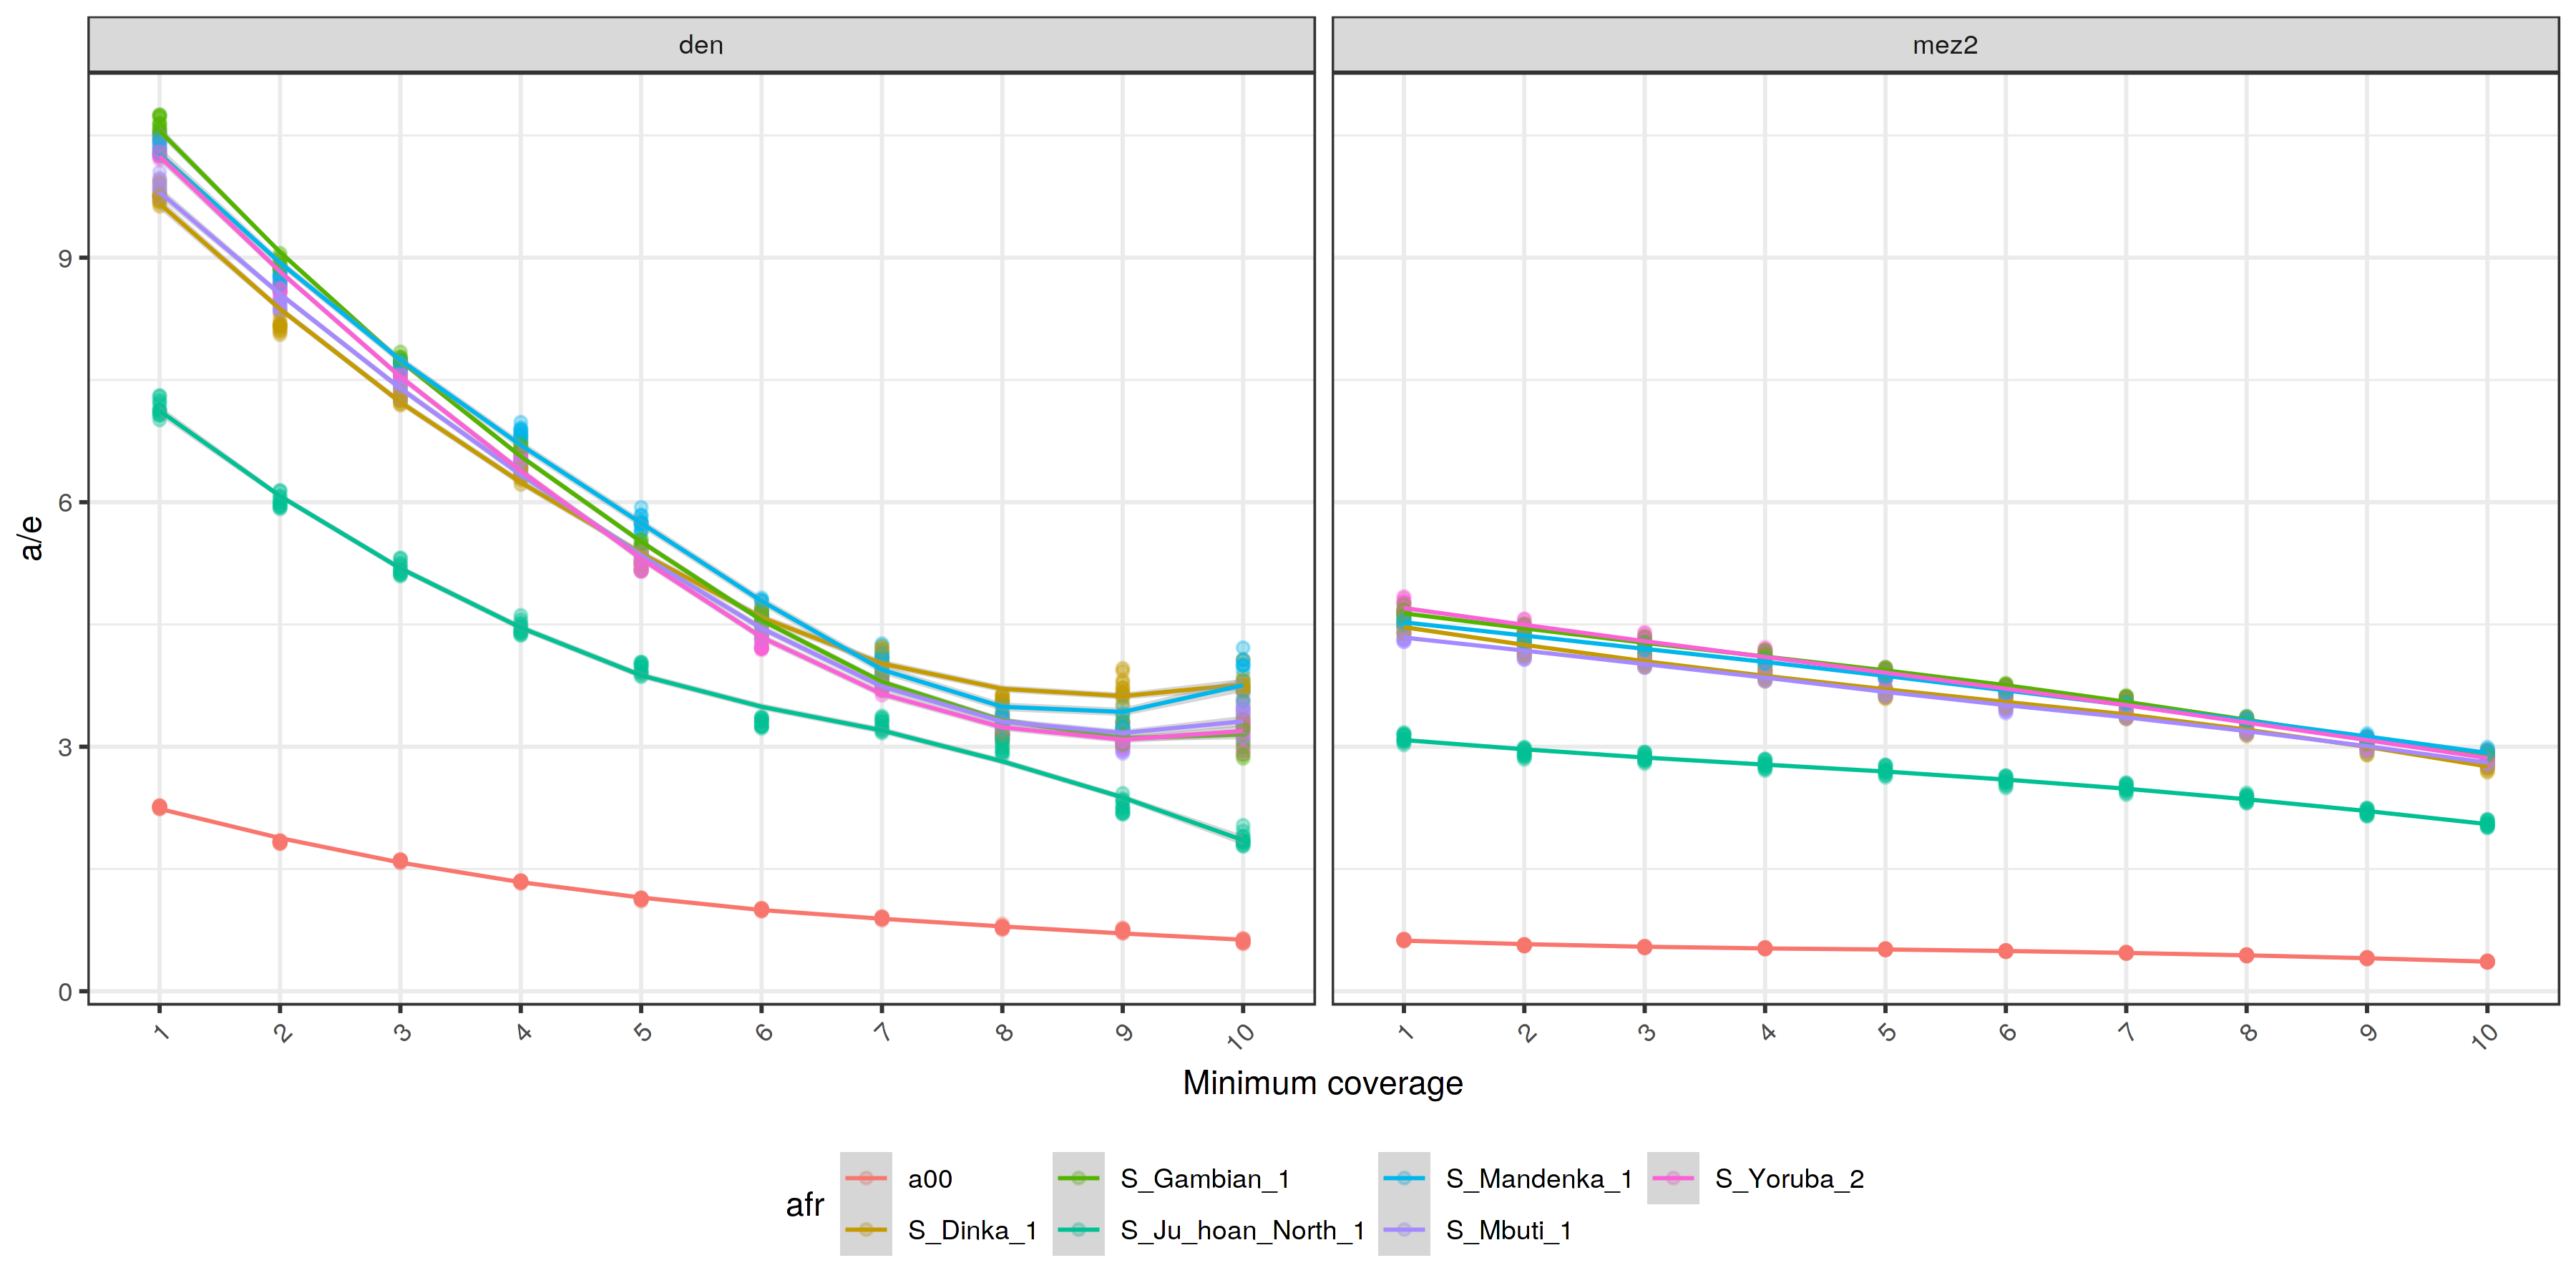

In [344]:
set_dim(12, 6)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(capture == "full", sites == "all", !arch %in% c("den8", "den4", "neand", "spy1")) %>% 
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts) %>%
ggplot(aes(as.factor(dp), a / e, color = afr)) +
    geom_point(alpha = 1/3) +
    geom_smooth(aes(group = afr), size = 0.5) +
    facet_wrap(arch ~ ., ncol = 6) +
    theme_bw() + xlab("Minimum coverage") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


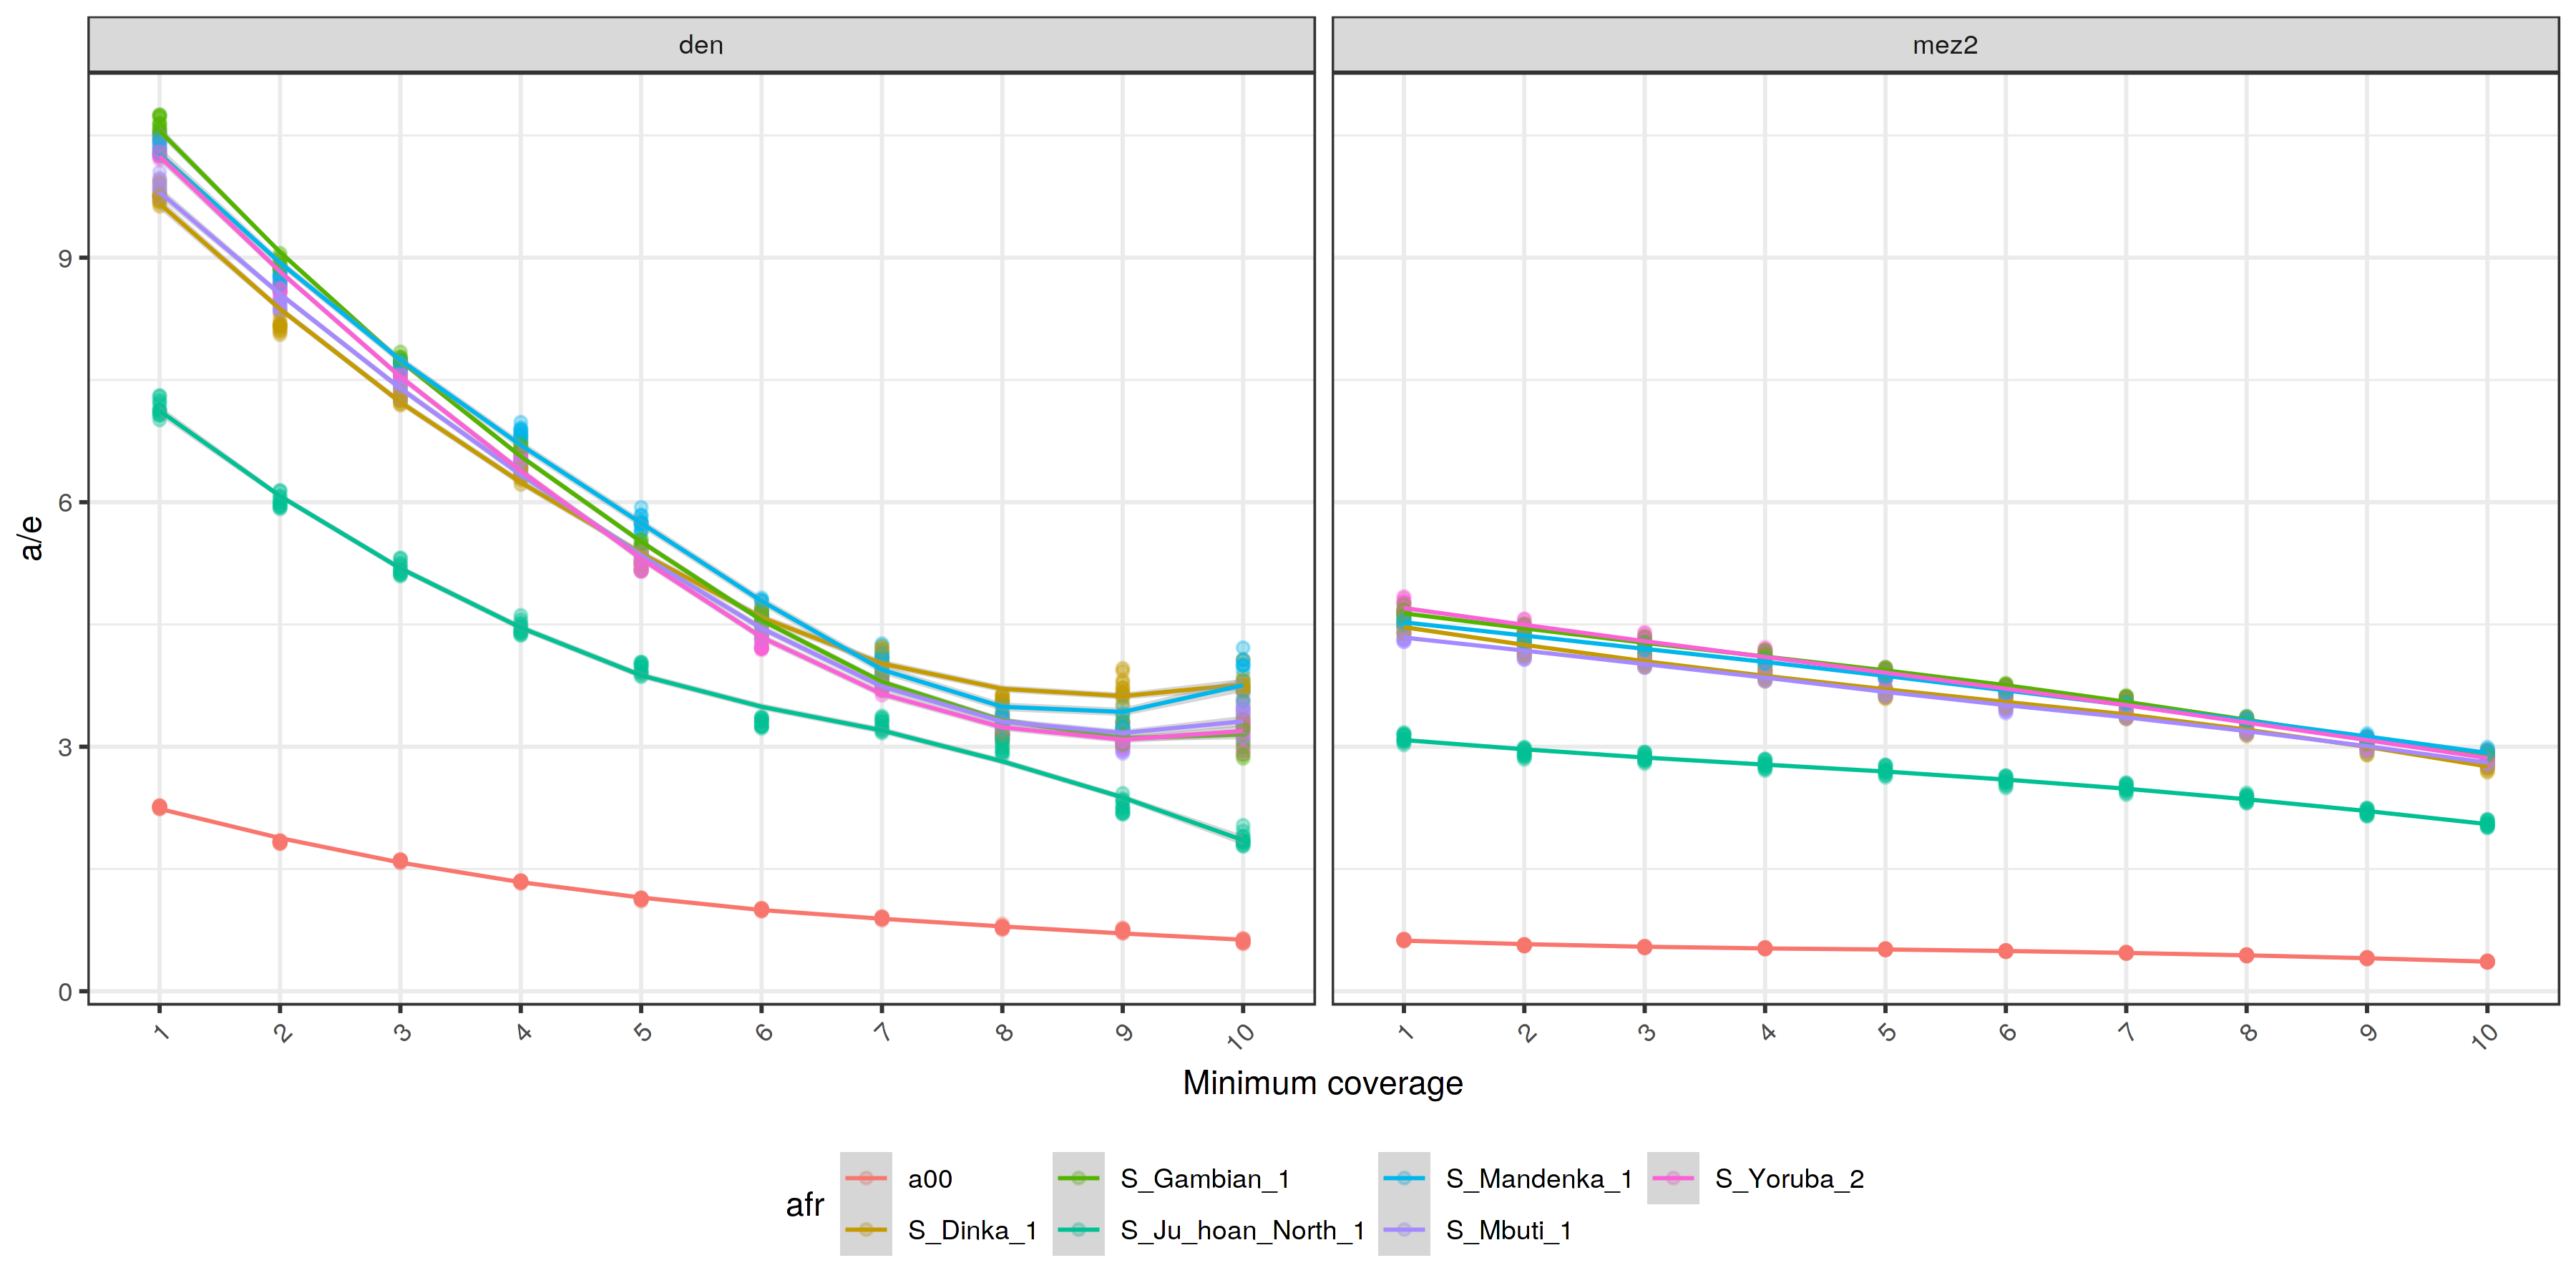

In [238]:
set_dim(12, 6)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(capture == "full", sites == "all", !arch %in% c("den8", "den4", "neand", "spy1")) %>% 
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts) %>%
ggplot(aes(as.factor(dp), a / e, color = afr)) +
    geom_point(alpha = 1/3) +
    geom_smooth(aes(group = afr), size = 0.5) +
    facet_wrap(arch ~ ., ncol = 6) +
    theme_bw() + xlab("Minimum coverage") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


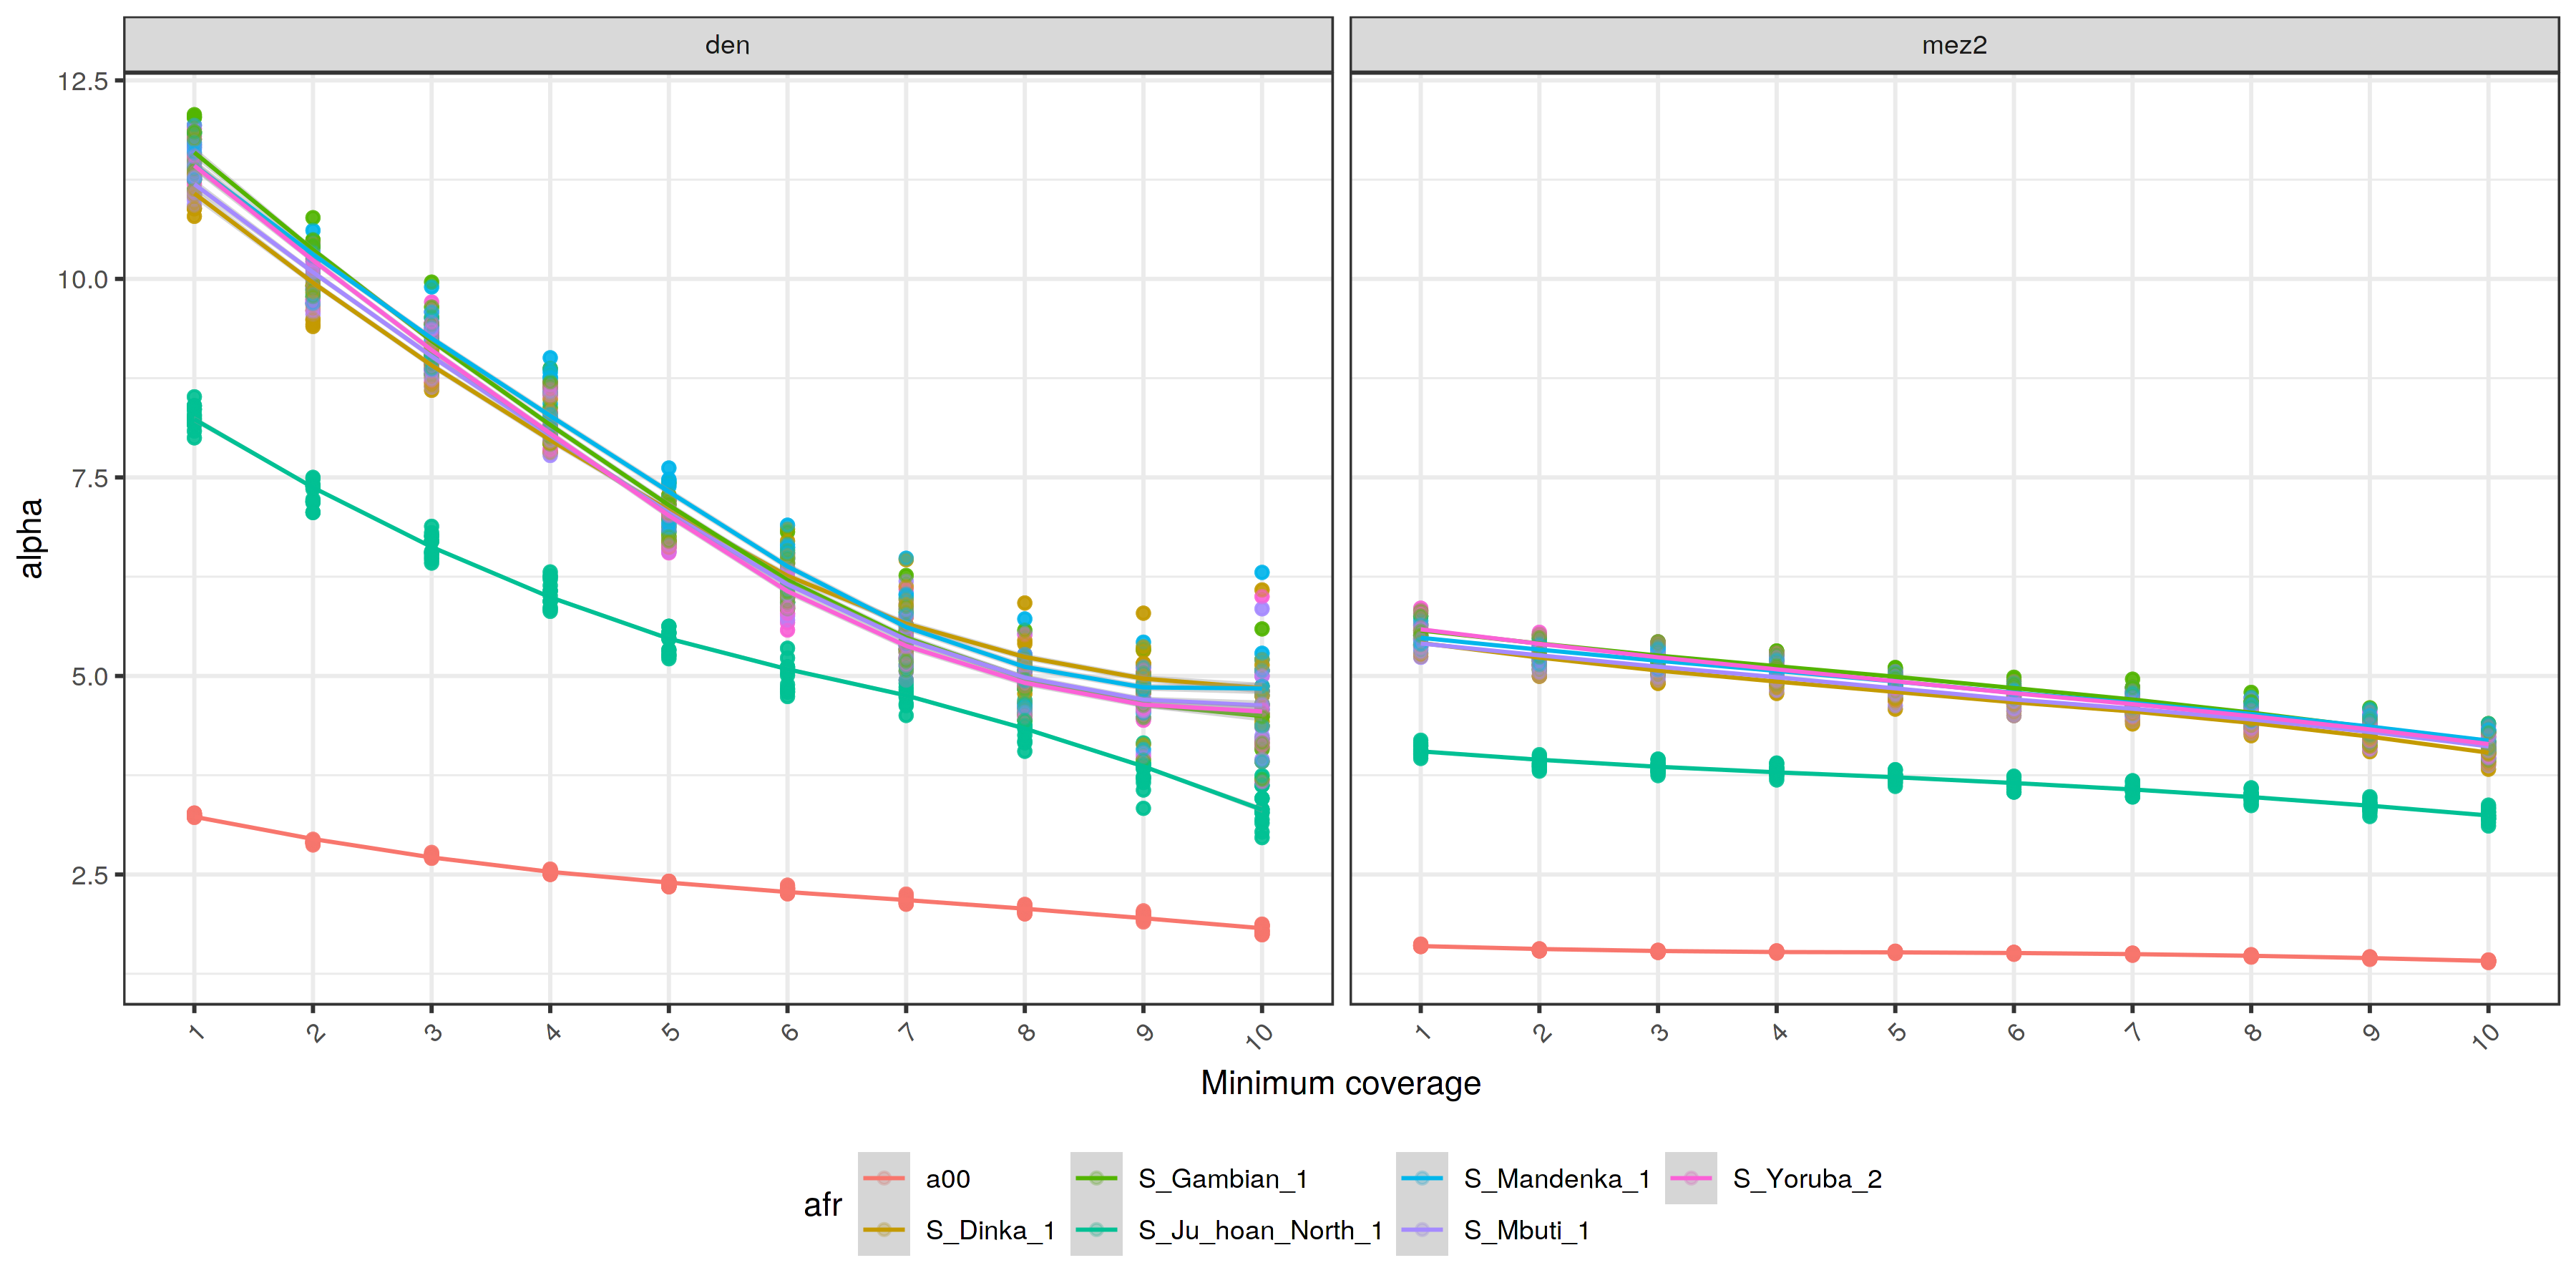

In [189]:
set_dim(12, 6)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(capture == "full", sites == "all", !arch %in% c("den8", "den4", "neand", "spy1")) %>% 
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts)) %>% 
mutate(prop = count / n_muts) %>%
ggplot(aes(as.factor(dp), alpha, color = afr)) +
    geom_point(alpha = 1/3) +
    geom_smooth(aes(group = afr), size = 0.5) +
    facet_wrap(arch ~ ., ncol = 6) +
    theme_bw() + xlab("Minimum coverage") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?

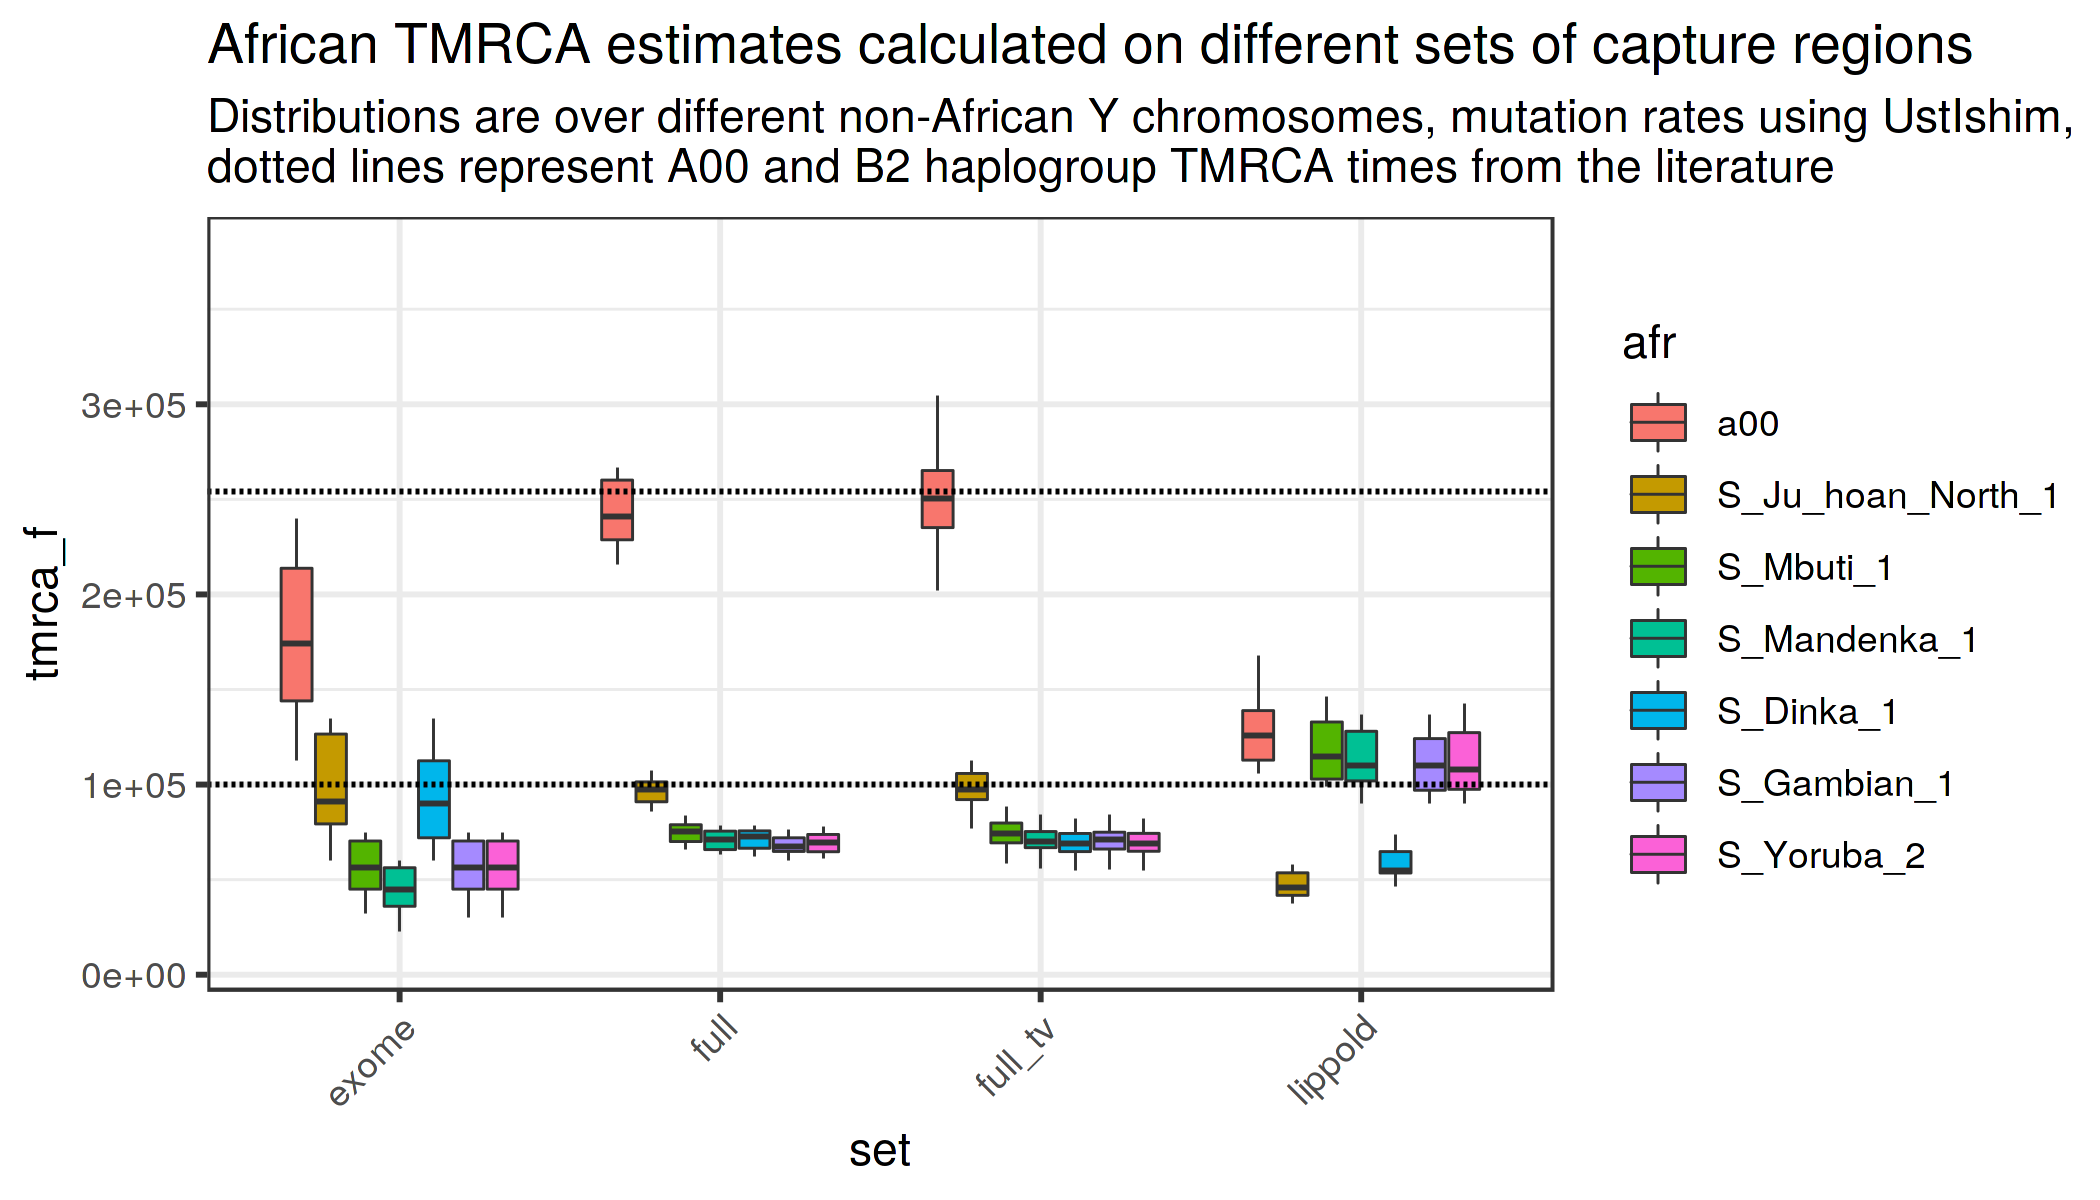

In [28]:
set_dim(7, 4)

tarch %>% filter(arch == "den8", !str_detect(set, "^x")) %>% 
ggplot(aes(set, tmrca_f, fill = fct_reorder(afr, tmrca_afr, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    coord_cartesian(y = c(10000, 380000)) +
    geom_hline(yintercept = c(254000, 100000), linetype = 2, size = 0.5) +
    guides(fill = guide_legend("afr")) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("African TMRCA estimates calculated on different sets of capture regions",
            "Distributions are over different non-African Y chromosomes, mutation rates using UstIshim,
dotted lines represent A00 and B2 haplogroup TMRCA times from the literature")

$\alpha$ values stable across capture sets for A00, for Denisovans and Neanderthals.

Much lower $\alpha$ values for exome and Lippold regions.

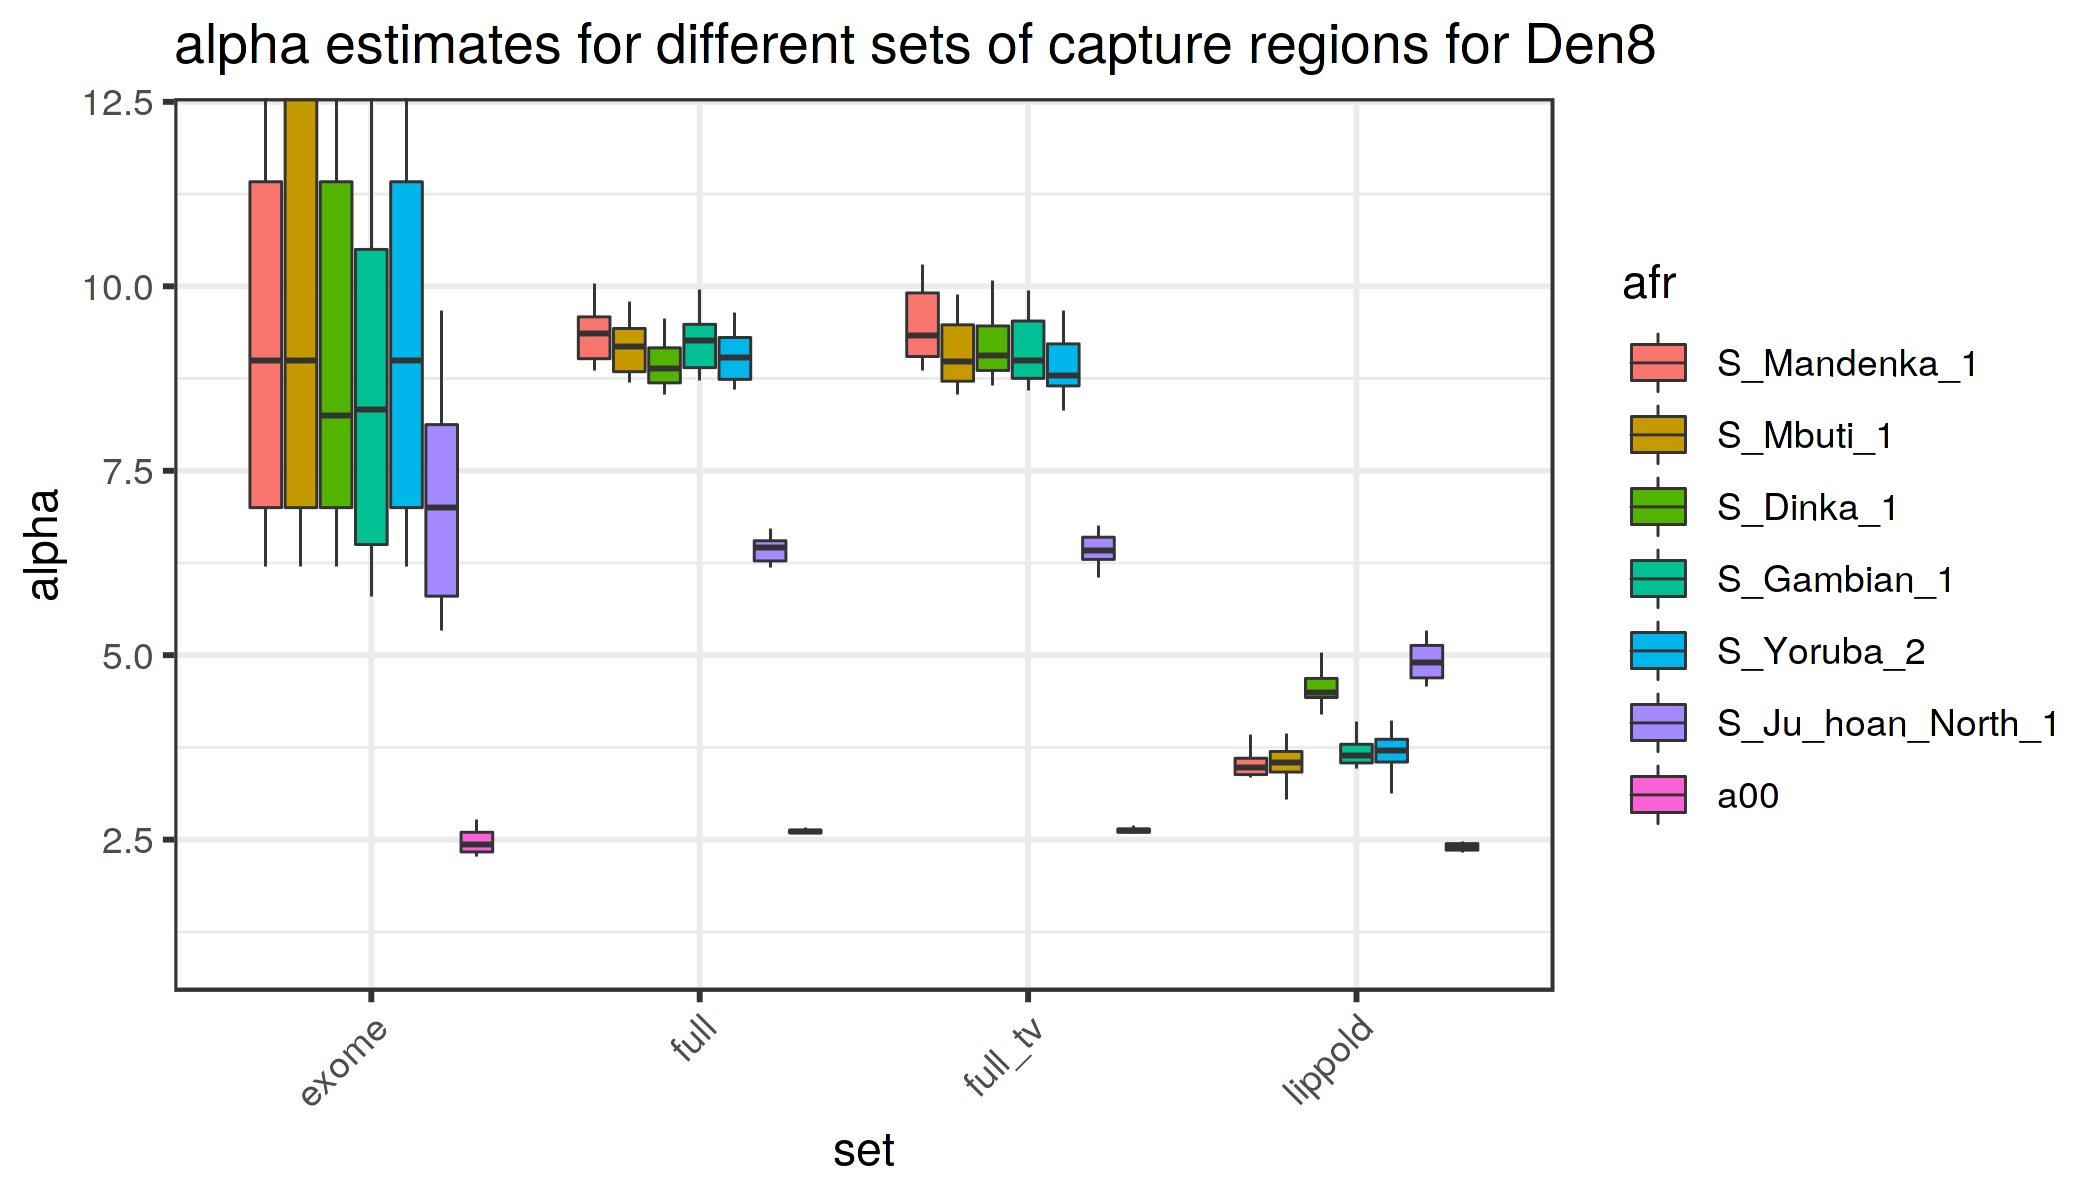

In [30]:
set_dim(7, 4)

tarch %>% filter(arch == "den8", !str_detect(set, "^x")) %>% 
ggplot(aes(set, alpha, fill = fct_reorder(afr, alpha, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    guides(fill = guide_legend("afr")) +
    coord_cartesian(y = c(1, 12)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("alpha estimates for different sets of capture regions for Den8")

Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”

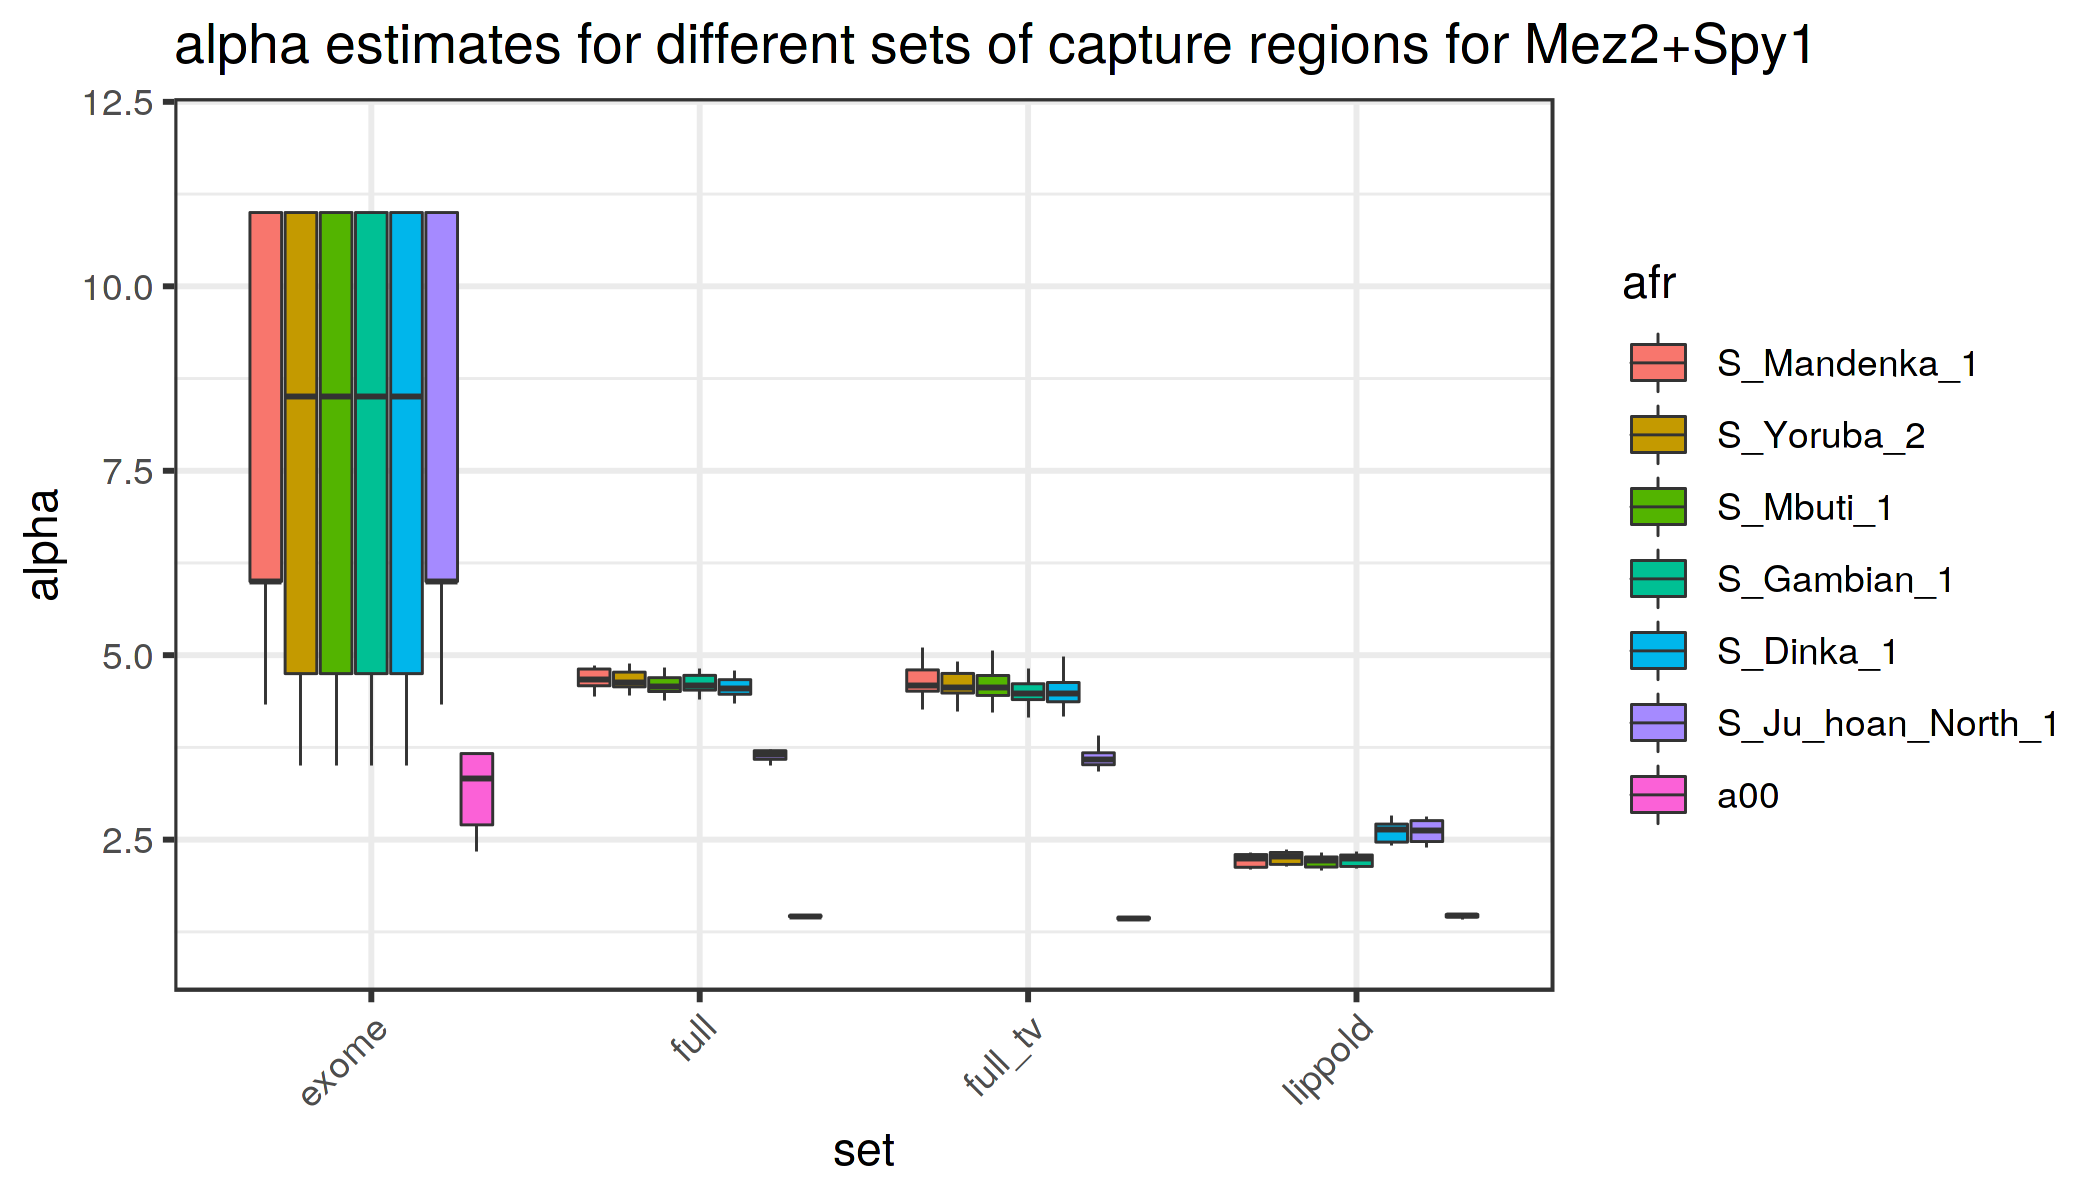

In [32]:
set_dim(7, 4)

tarch %>% filter(arch == "neand", !str_detect(set, "^x")) %>% 
ggplot(aes(set, alpha, fill = fct_reorder(afr, alpha, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    guides(fill = guide_legend("afr")) +
    coord_cartesian(y = c(1, 12)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("alpha estimates for different sets of capture regions for Mez2+Spy1")

Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”

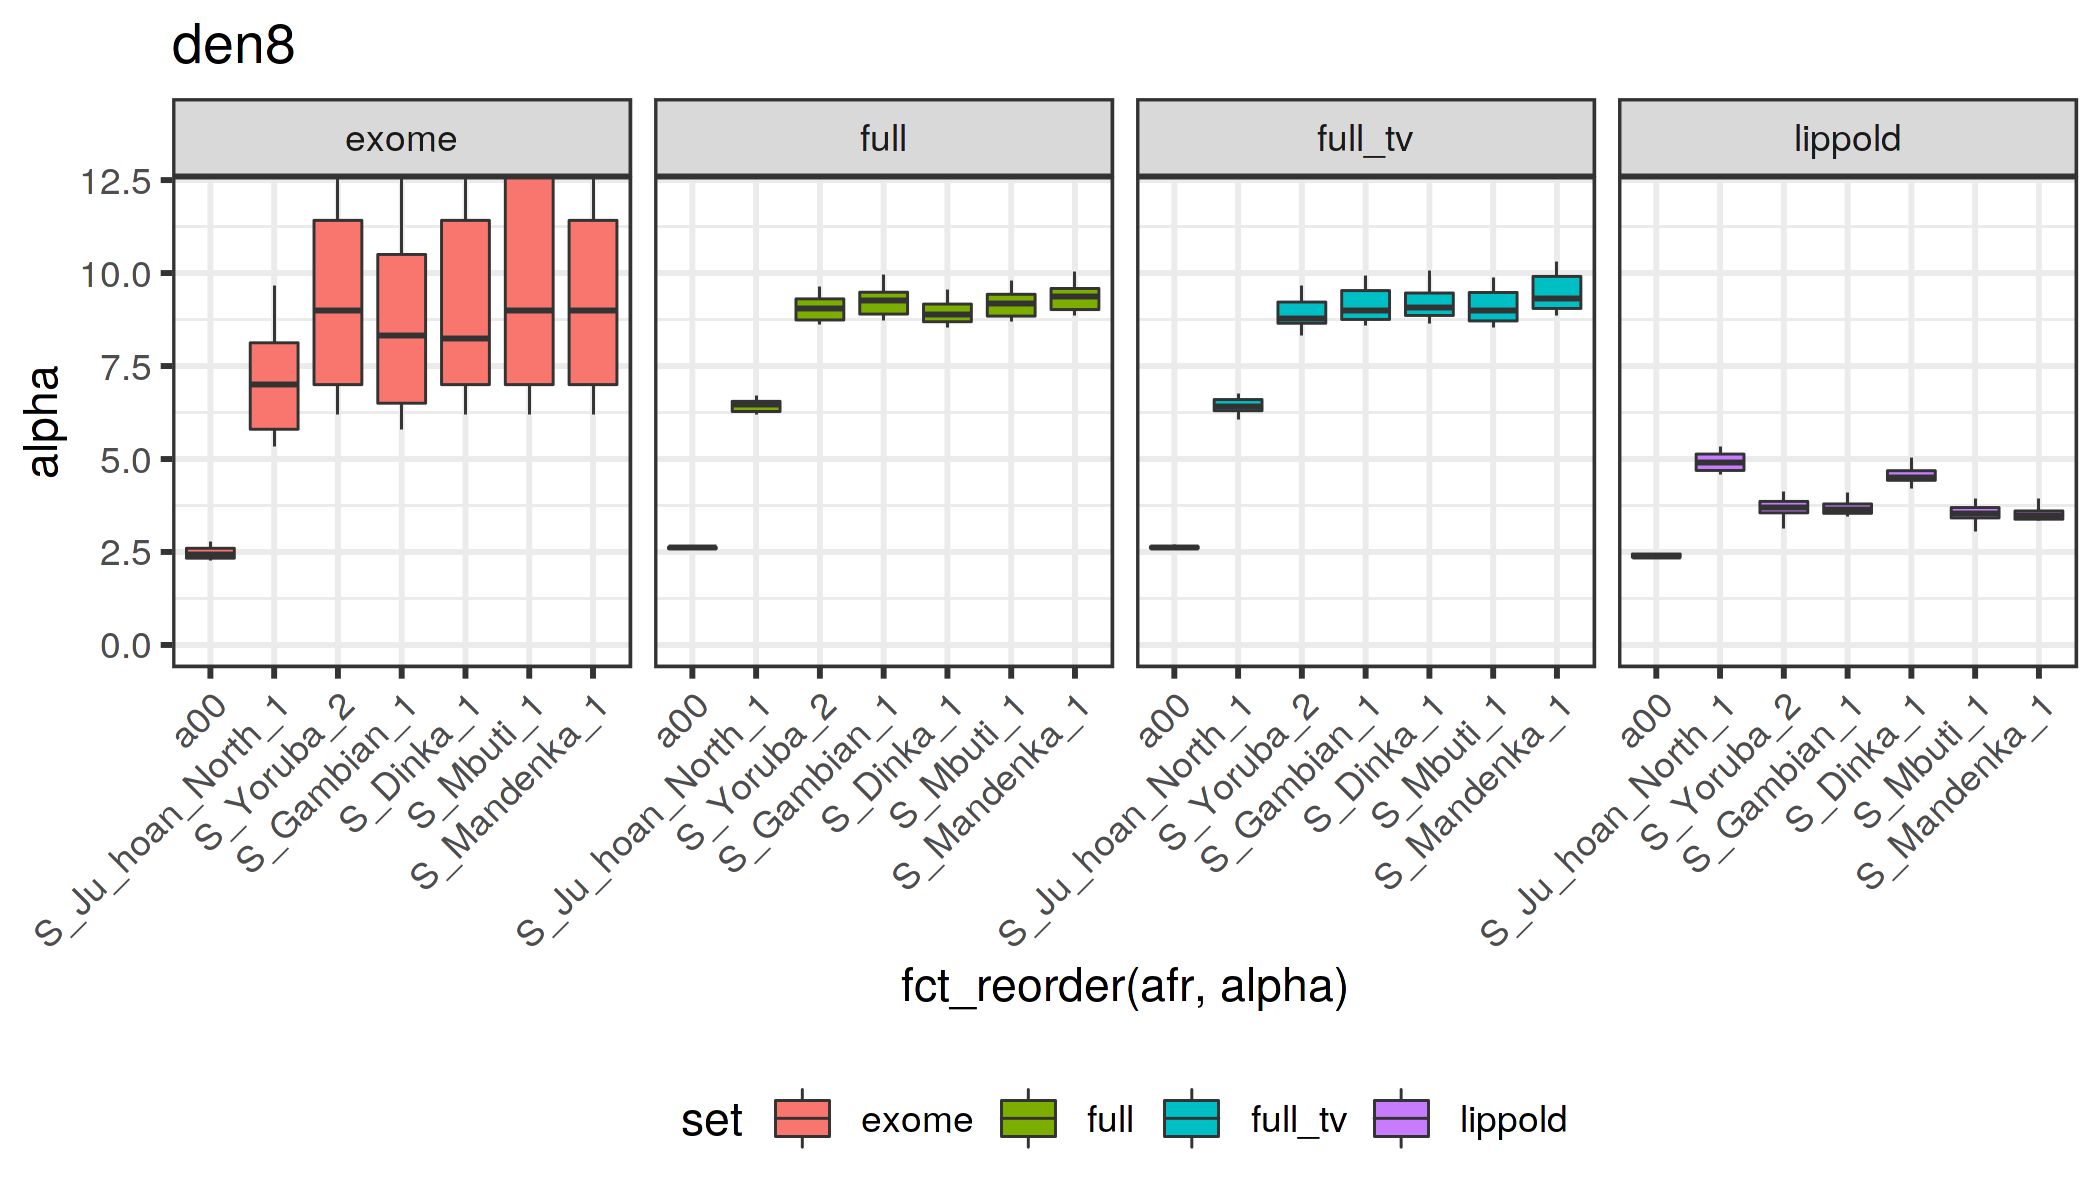

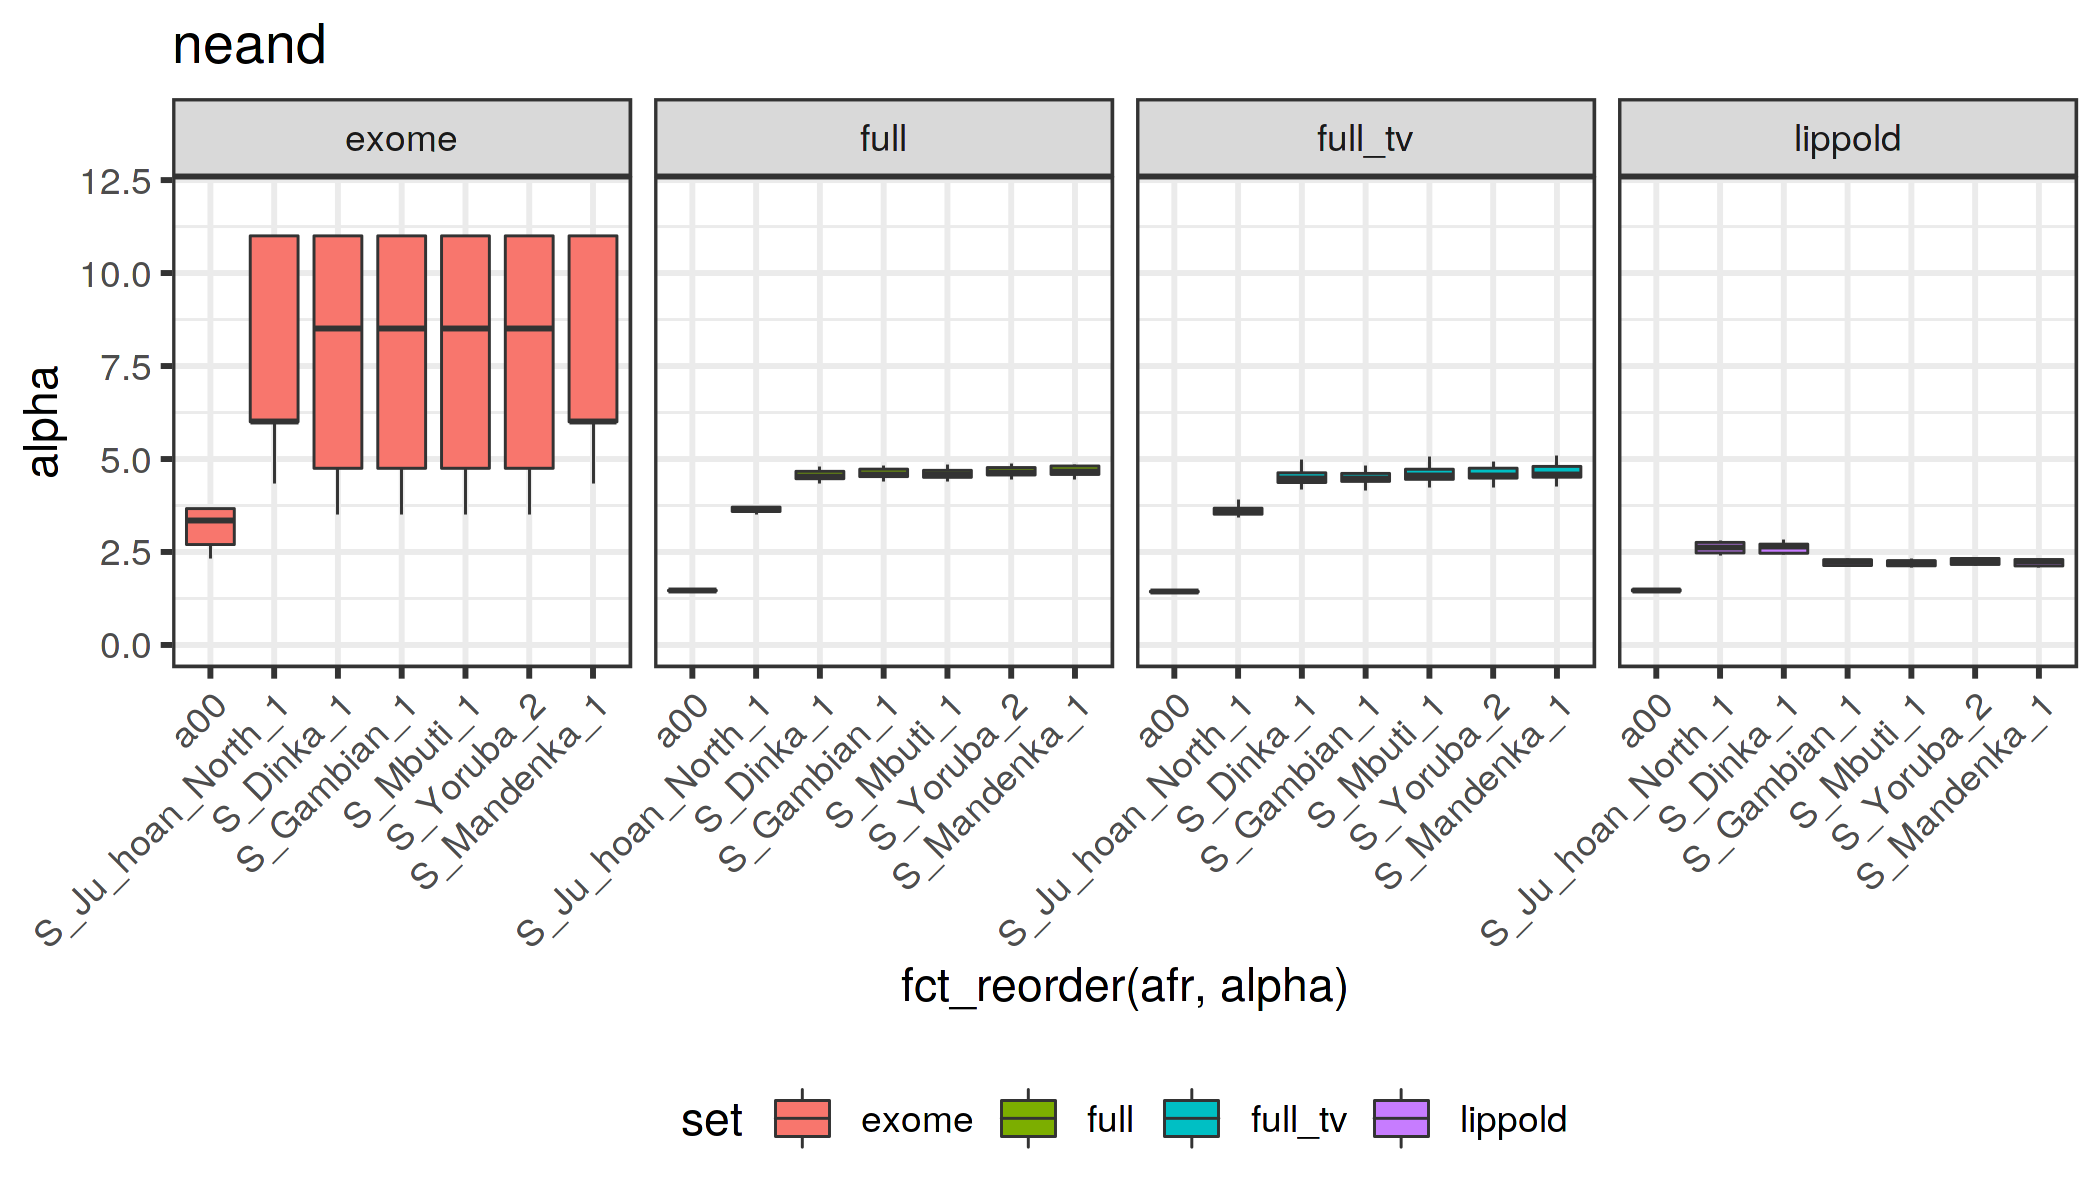

In [12]:
set_dim(7, 4)

tmrca %>% filter(arch == "den8") %>% 
unnest(counts_arch) %>%
ggplot(aes(fct_reorder(afr, alpha), alpha, fill = set)) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    facet_wrap(~ set, ncol = 4) +
    guides(fill = guide_legend("set")) +
    coord_cartesian(y = c(0, 12)) +
    theme_bw() +
    ggtitle("den8") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

tmrca %>% filter(arch == "neand") %>% 
unnest(counts_arch) %>%
ggplot(aes(fct_reorder(afr, alpha), alpha, fill = set)) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    facet_wrap(~ set, ncol = 4) +
    guides(fill = guide_legend("set")) +
    coord_cartesian(y = c(0, 12)) +
    theme_bw() +
    ggtitle("neand") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

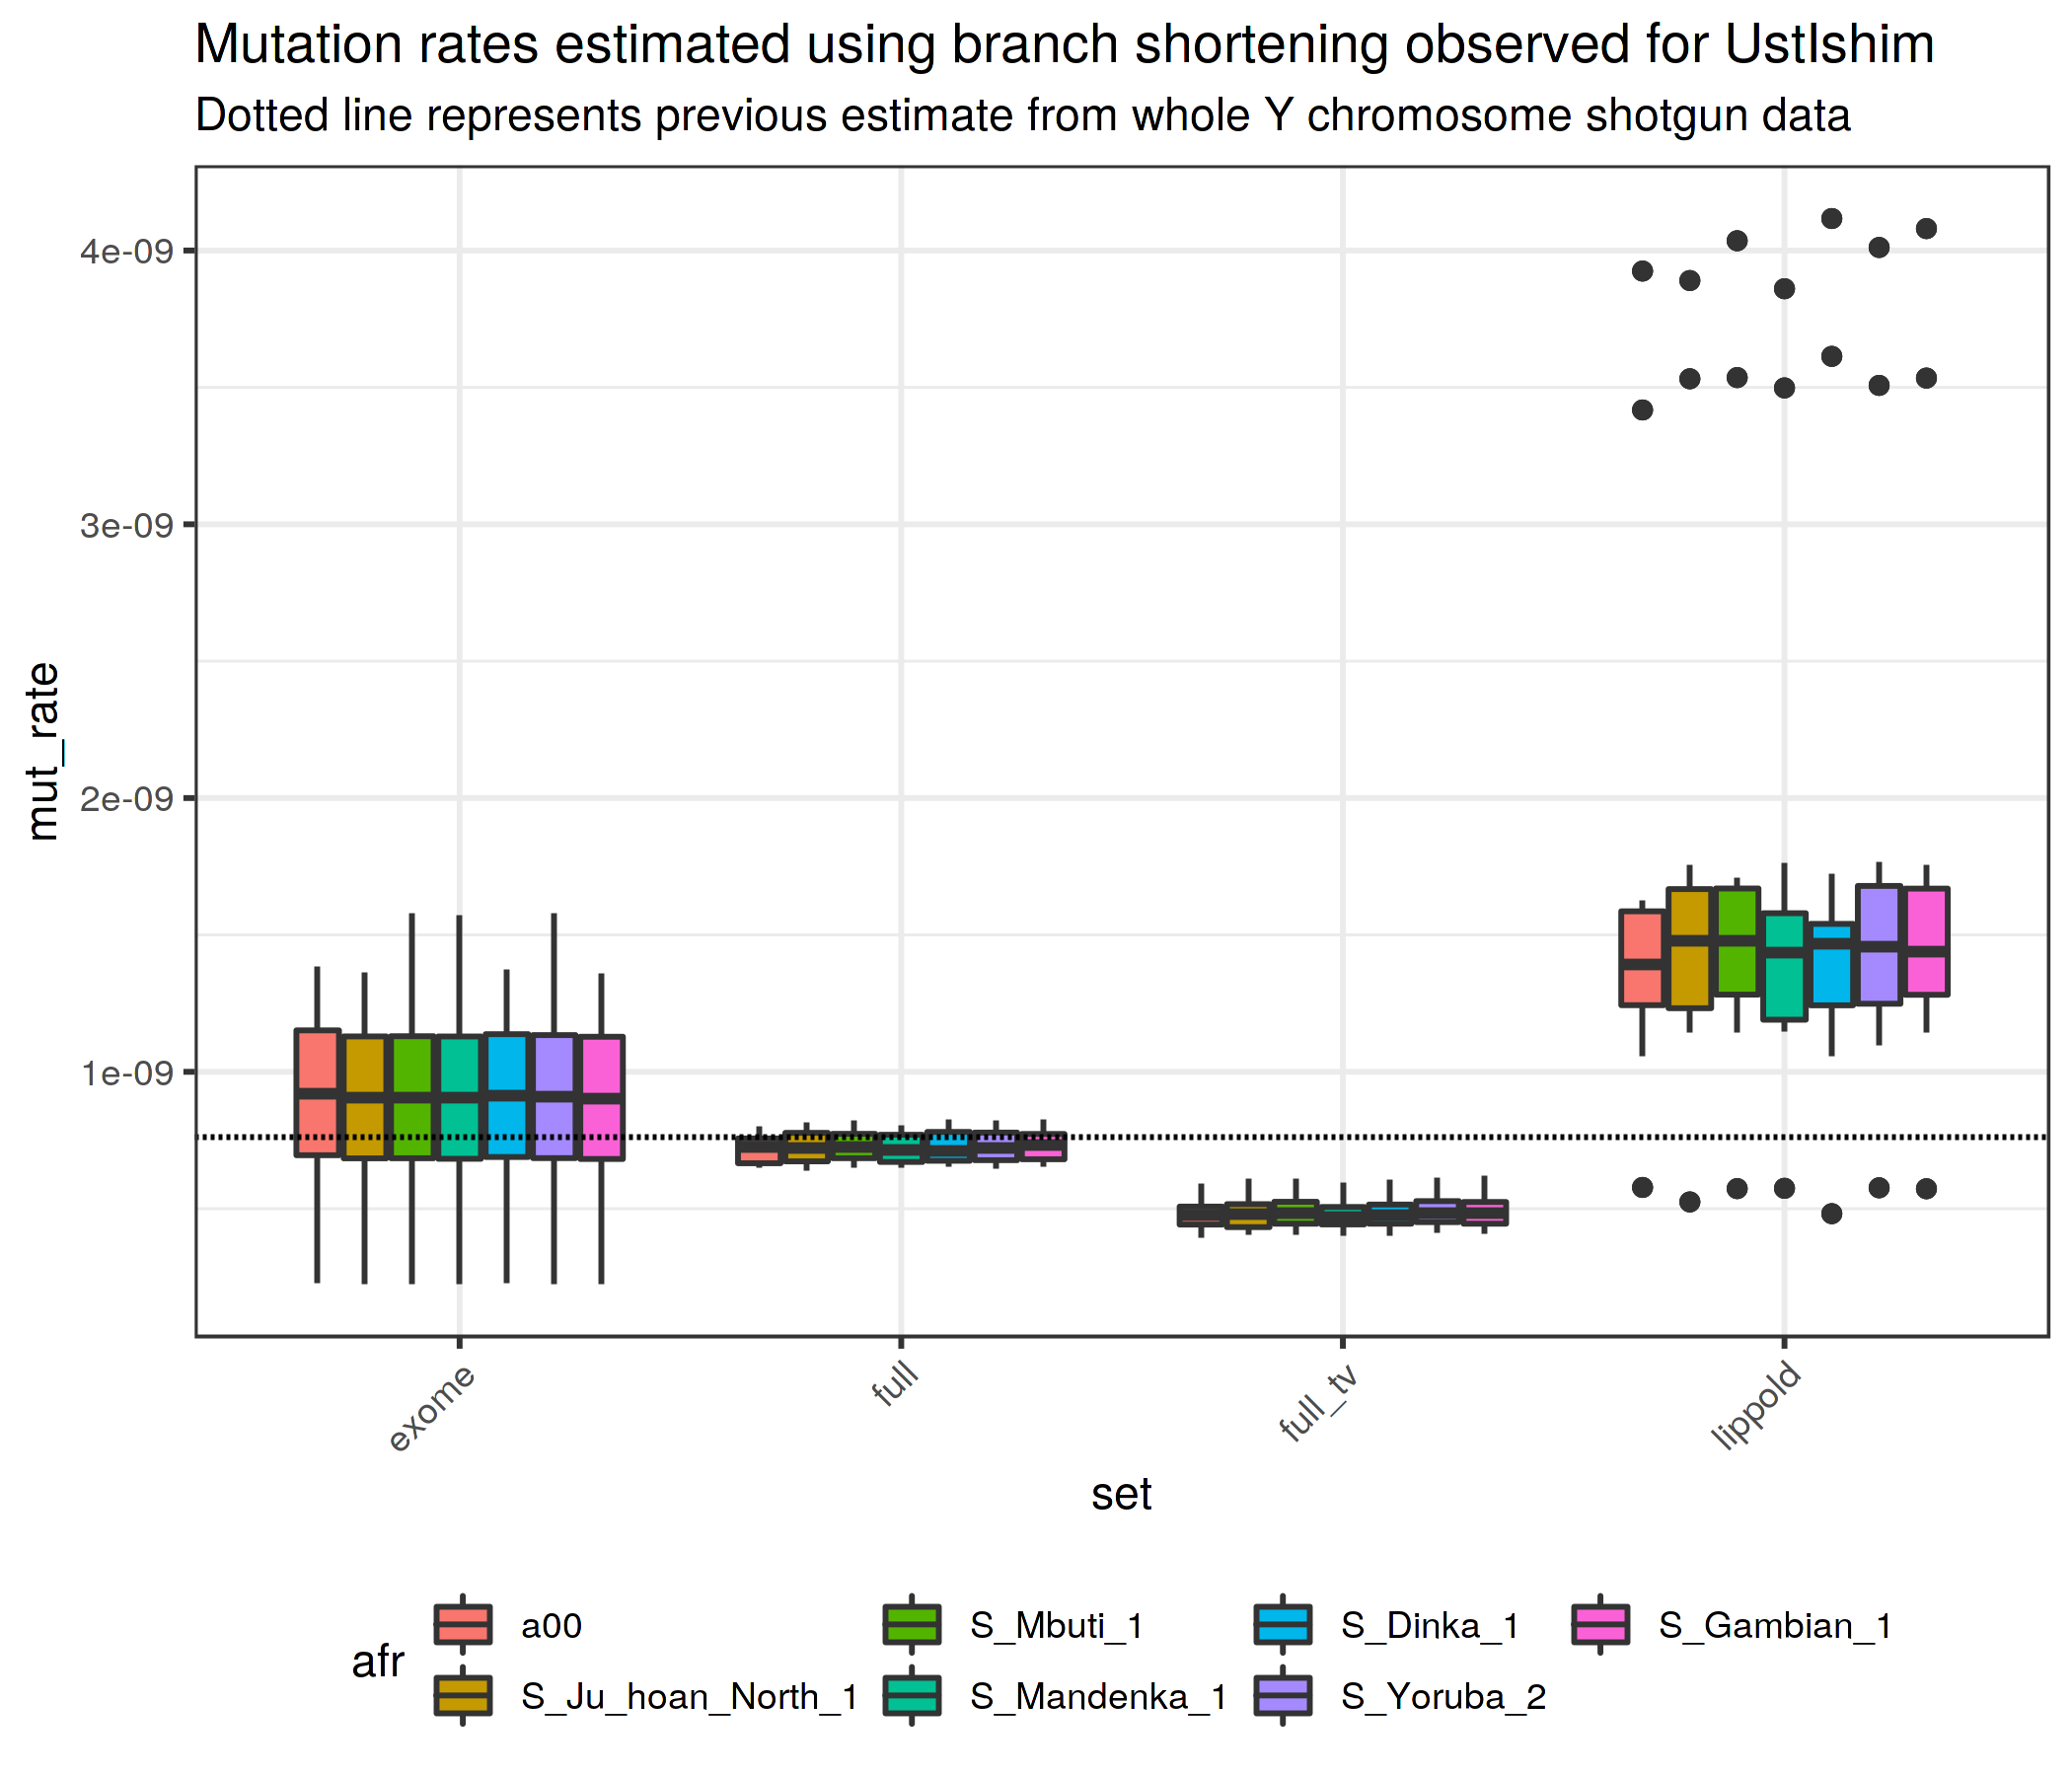

In [13]:
set_dim(7, 6)

tmrca %>%
ggplot(aes(set, mut_rate, fill = fct_reorder(afr, tmrca_afr, .desc = TRUE))) +
    geom_boxplot() +
    geom_hline(yintercept = 7.6e-10, linetype = 2, size = 0.5) +
    guides(fill = guide_legend("afr")) +
    theme_bw() +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Mutation rates estimated using branch shortening observed for UstIshim",
            "Dotted line represents previous estimate from whole Y chromosome shotgun data")

In [74]:
a = 8
d = 7
e = 5

In [100]:
a = 870
d = 457
e = 612

In [91]:
a = 164
d = 306
e = 396

In [101]:
a / (a + d + e)

[1] 0.4486849

In [102]:
p_ci <- binom.test(x = a, n = a + d + e, conf.level = 0.95)$conf.int
p_ci[1]
p_ci[2]

[1] 0.4263813

[1] 0.4711439

In [103]:
(alpha_ci <- (1 + p_ci)/(1 - p_ci))

[1] 2.486637 2.781747
attr(,"conf.level")
[1] 0.95

In [104]:
alpha_ci * 254000

[1] 631605.7 706563.8
attr(,"conf.level")
[1] 0.95

In [98]:
alpha_ci * 254000

[1] 353507.5 394860.8
attr(,"conf.level")
[1] 0.95

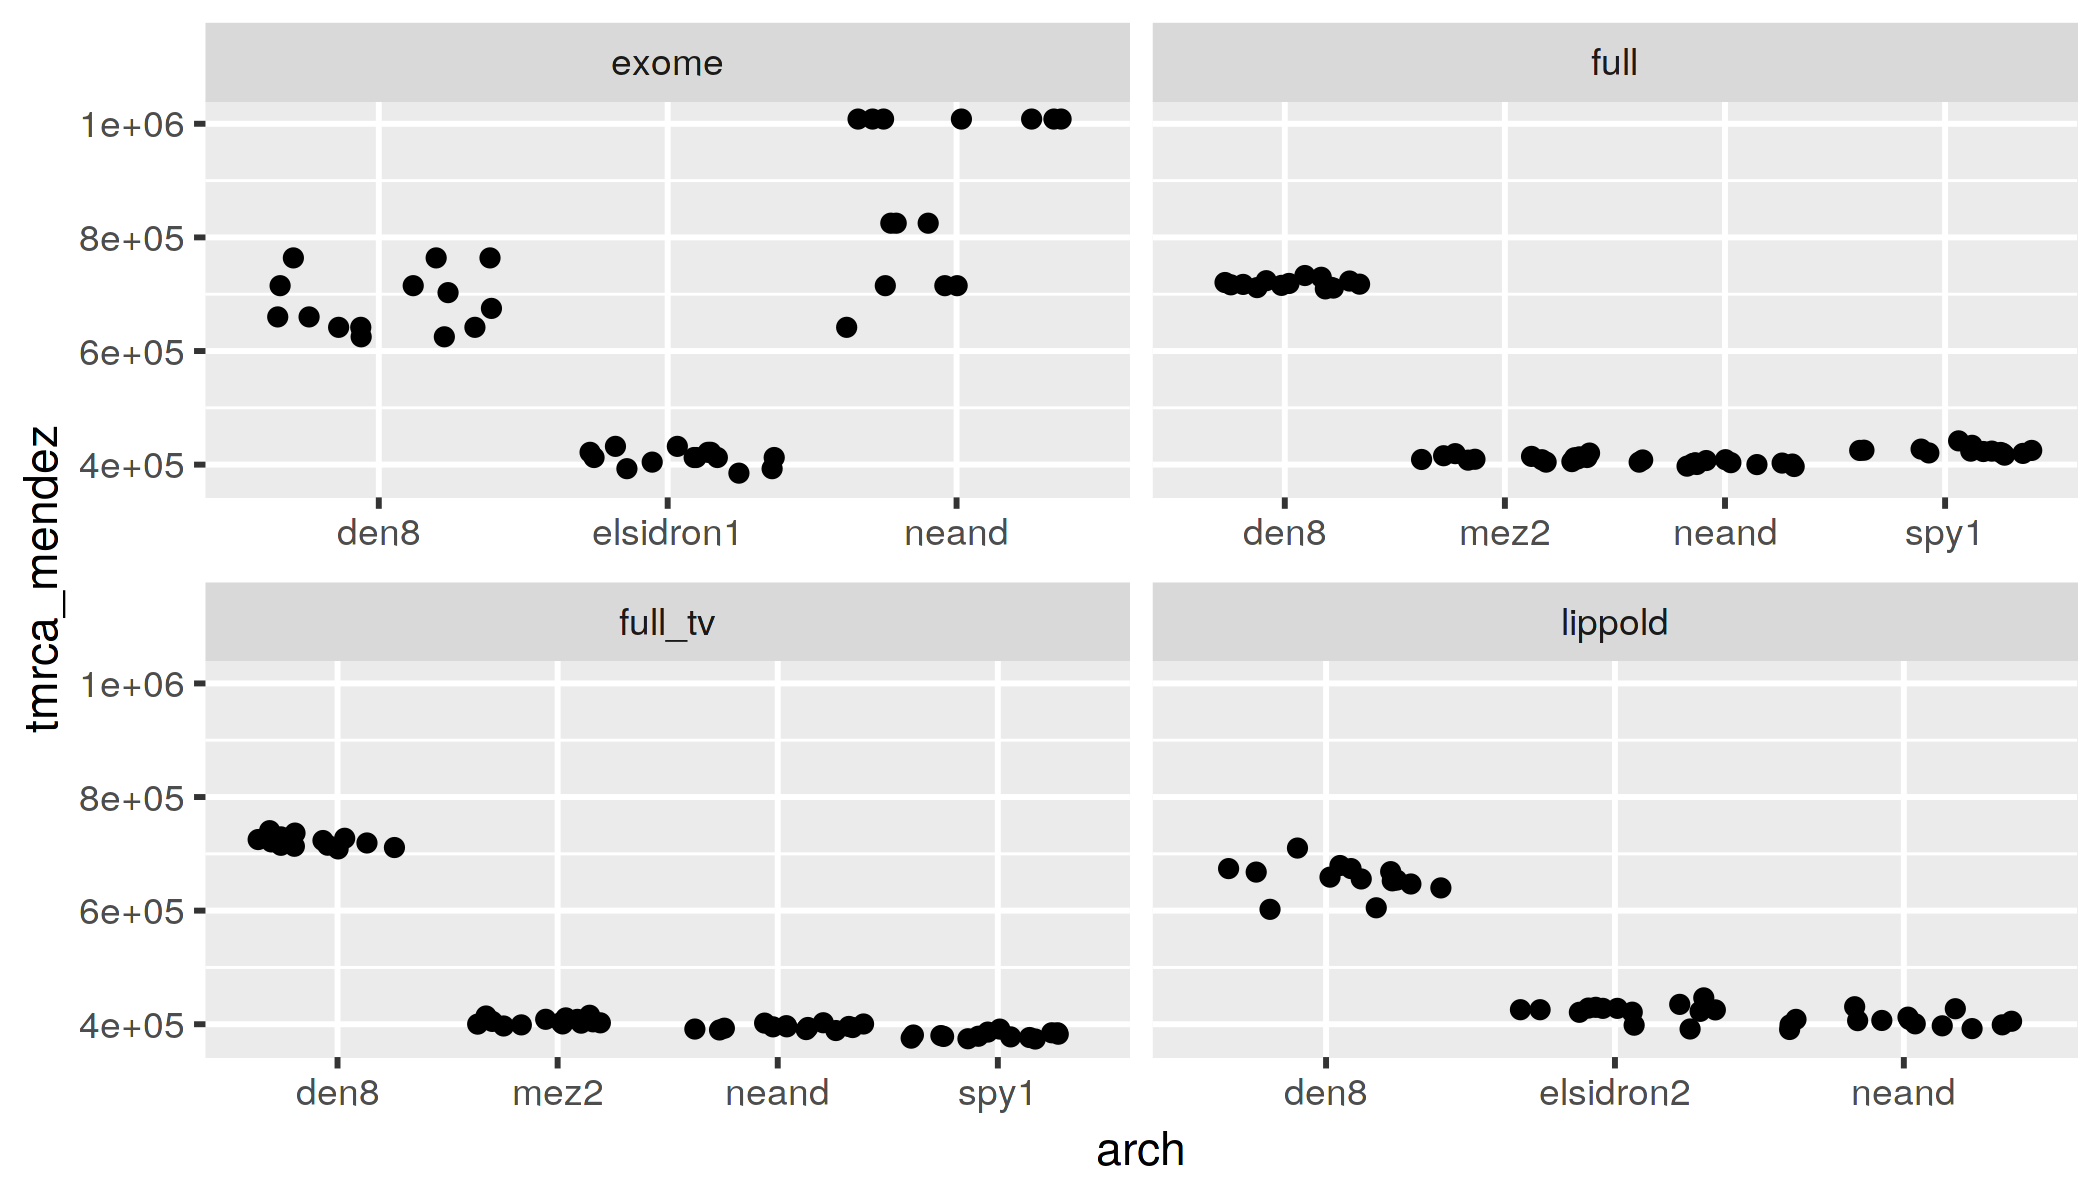

In [53]:
tarch %>%
    filter(afr == "a00") %>%
    unnest(counts_arch) %>%
    ggplot(aes(arch, tmrca_mendez)) + geom_jitter() + facet_wrap(~ set, scales = "free_x")

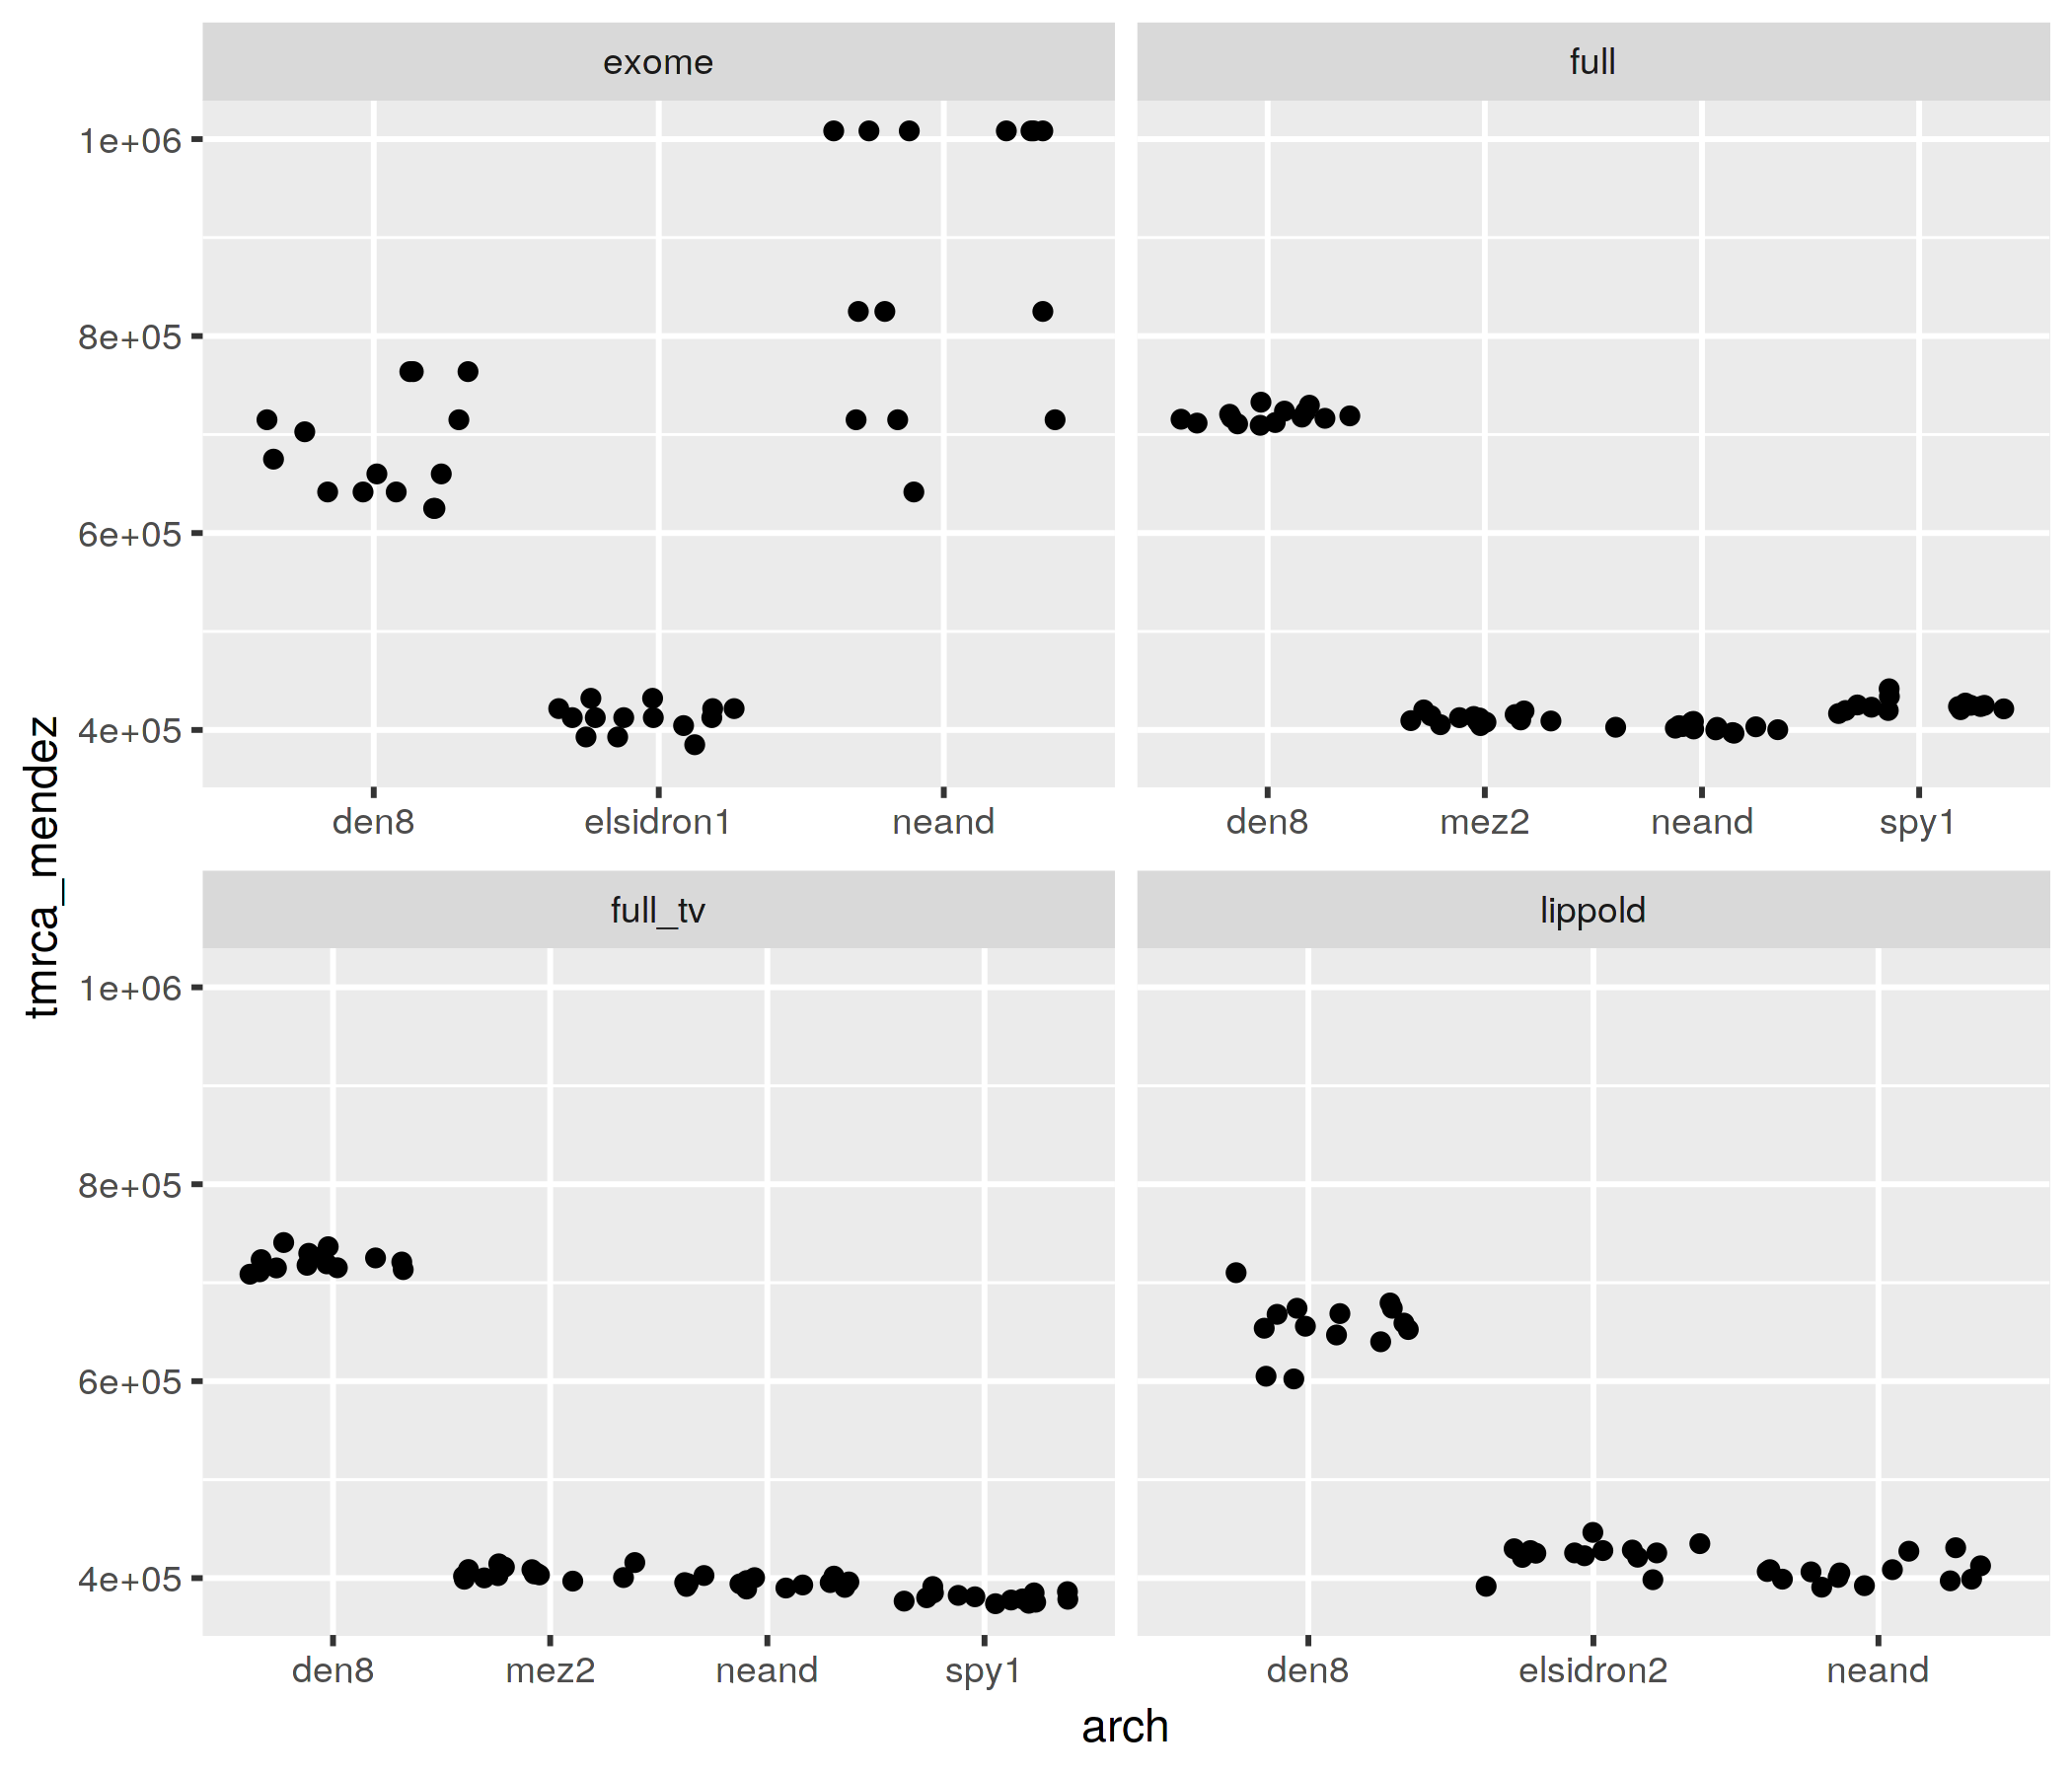

In [14]:
tmrca %>%
    filter(afr == "a00") %>%
    unnest(counts_arch) %>%
    ggplot(aes(arch, tmrca_mendez)) + geom_jitter() + facet_wrap(~ set, scales = "free_x")

In [55]:
tarch %>%
    filter(set == "exome", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch      afr tmrca_arch alpha    tmrca_afr tmrca_ad tmrca_f  mut_rate    
1 den8      a00 575947.2   2.492063 228214.3  237642.9 218785.7 9.357731e-10
2 elsidron1 a00 341020.4   1.497899 228214.3  237642.9 218785.7 9.357731e-10
3 neand     a00 753321.4   3.200000 228214.3  237642.9 218785.7 9.357731e-10
  tmrca_mendez a        b c d        e        f         total   
1 685317.5     7.500000 1 0 5.285714 4.857143  9.285714 32952.64
2 411922.3     3.785714 0 0 8.357143 6.857143 10.714286 48727.93
3 880000.0     4.000000 0 0 1.857143 2.000000 11.000000 20395.14

In [16]:
tmrca %>%
    filter(set == "exome", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch      afr tmrca_arch alpha    tmrca_afr tmrca_ad tmrca_f  mut_rate    
1 den8      a00 575947.2   2.492063 228214.3  237642.9 218785.7 9.357731e-10
2 elsidron1 a00 341020.4   1.497899 228214.3  237642.9 218785.7 9.357731e-10
3 neand     a00 753321.4   3.200000 228214.3  237642.9 218785.7 9.357731e-10
  tmrca_mendez a        b c d        e        f         total   
1 685317.5     7.500000 1 0 5.285714 4.857143  9.285714 32952.64
2 411922.3     3.785714 0 0 8.357143 6.857143 10.714286 48727.93
3 880000.0     4.000000 0 0 1.857143 2.000000 11.000000 20395.14

In [17]:
tmrca %>%
    filter(set == "lippold", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch      afr tmrca_arch alpha    tmrca_afr tmrca_ad tmrca_f  mut_rate    
1 den8      a00 387095.2   2.386814 160020.1  189863.9 130176.2 1.628451e-09
2 elsidron2 a00 248851.7   1.539517 160020.1  189863.9 130176.2 1.628451e-09
3 neand     a00 237332.7   1.476630 160020.1  189863.9 130176.2 1.628451e-09
  tmrca_mendez a        b          c        d         e        f       
1 656373.9     73.07143 1.92857143 2.428571  58.92857 47.00000 82.78571
2 423367.1     47.21429 1.92857143 5.285714 106.21429 70.50000 88.92857
3 406073.4     16.71429 0.07142857 1.857143  36.21429 34.21429 58.14286
  total   
1 295207.9
2 409403.7
3 190576.6

In [19]:
tmrca %>%
    filter(set == "full", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch  afr tmrca_arch alpha    tmrca_afr tmrca_ad tmrca_f  mut_rate    
1 den8  a00 689054.0   2.612988 263713.1  285163.6 242262.6 7.199248e-10
2 mez2  a00 394607.1   1.496869 263713.1  285163.6 242262.6 7.199248e-10
3 neand a00 386007.1   1.464270 263713.1  285163.6 242262.6 7.199248e-10
4 spy1  a00 407286.7   1.544736 263713.1  285163.6 242262.6 7.199248e-10
  tmrca_mendez a         b        c         d         e        f        
1 718571.8     834.00000 32.28571 13.571429 457.07143 577.2143 1083.0000
2 411638.9      87.57143 13.85714  8.857143 170.71429 182.0000  521.2143
3 402674.3     157.21429 19.28571 10.214286 310.92857 366.5714  736.8571
4 424802.5      35.35714  7.50000  0.500000  57.42857  72.5000  632.7143
  total    
1 3293926.1
2 1155292.5
3 2210584.1
4  530750.1

In [20]:
tmrca %>%
    filter(set == "full_tv", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch  afr tmrca_arch alpha    tmrca_afr tmrca_ad tmrca_f  mut_rate    
1 den8  a00 737291.2   2.624425 281002.5  311236.3 250768.7 4.812289e-10
2 mez2  a00 413751.3   1.473341 281002.5  311236.3 250768.7 4.812289e-10
3 neand a00 403483.0   1.436924 281002.5  311236.3 250768.7 4.812289e-10
4 spy1  a00 388640.2   1.383652 281002.5  311236.3 250768.7 4.812289e-10
  tmrca_mendez a         b        c         d         e         f        
1 721716.9     564.50000 8.785714 8.6428571 301.85714 393.35714 558.14286
2 405168.7      51.28571 2.071429 6.6428571 109.42857 107.50000 115.42857
3 395154.2      96.64286 6.500000 7.2142857 205.21429 237.42857 220.42857
4 380504.3      17.14286 4.428571 0.2142857  39.78571  49.71429  90.78571
  total    
1 3264232.0
2 1143478.6
3 2190185.2
4  525485.4

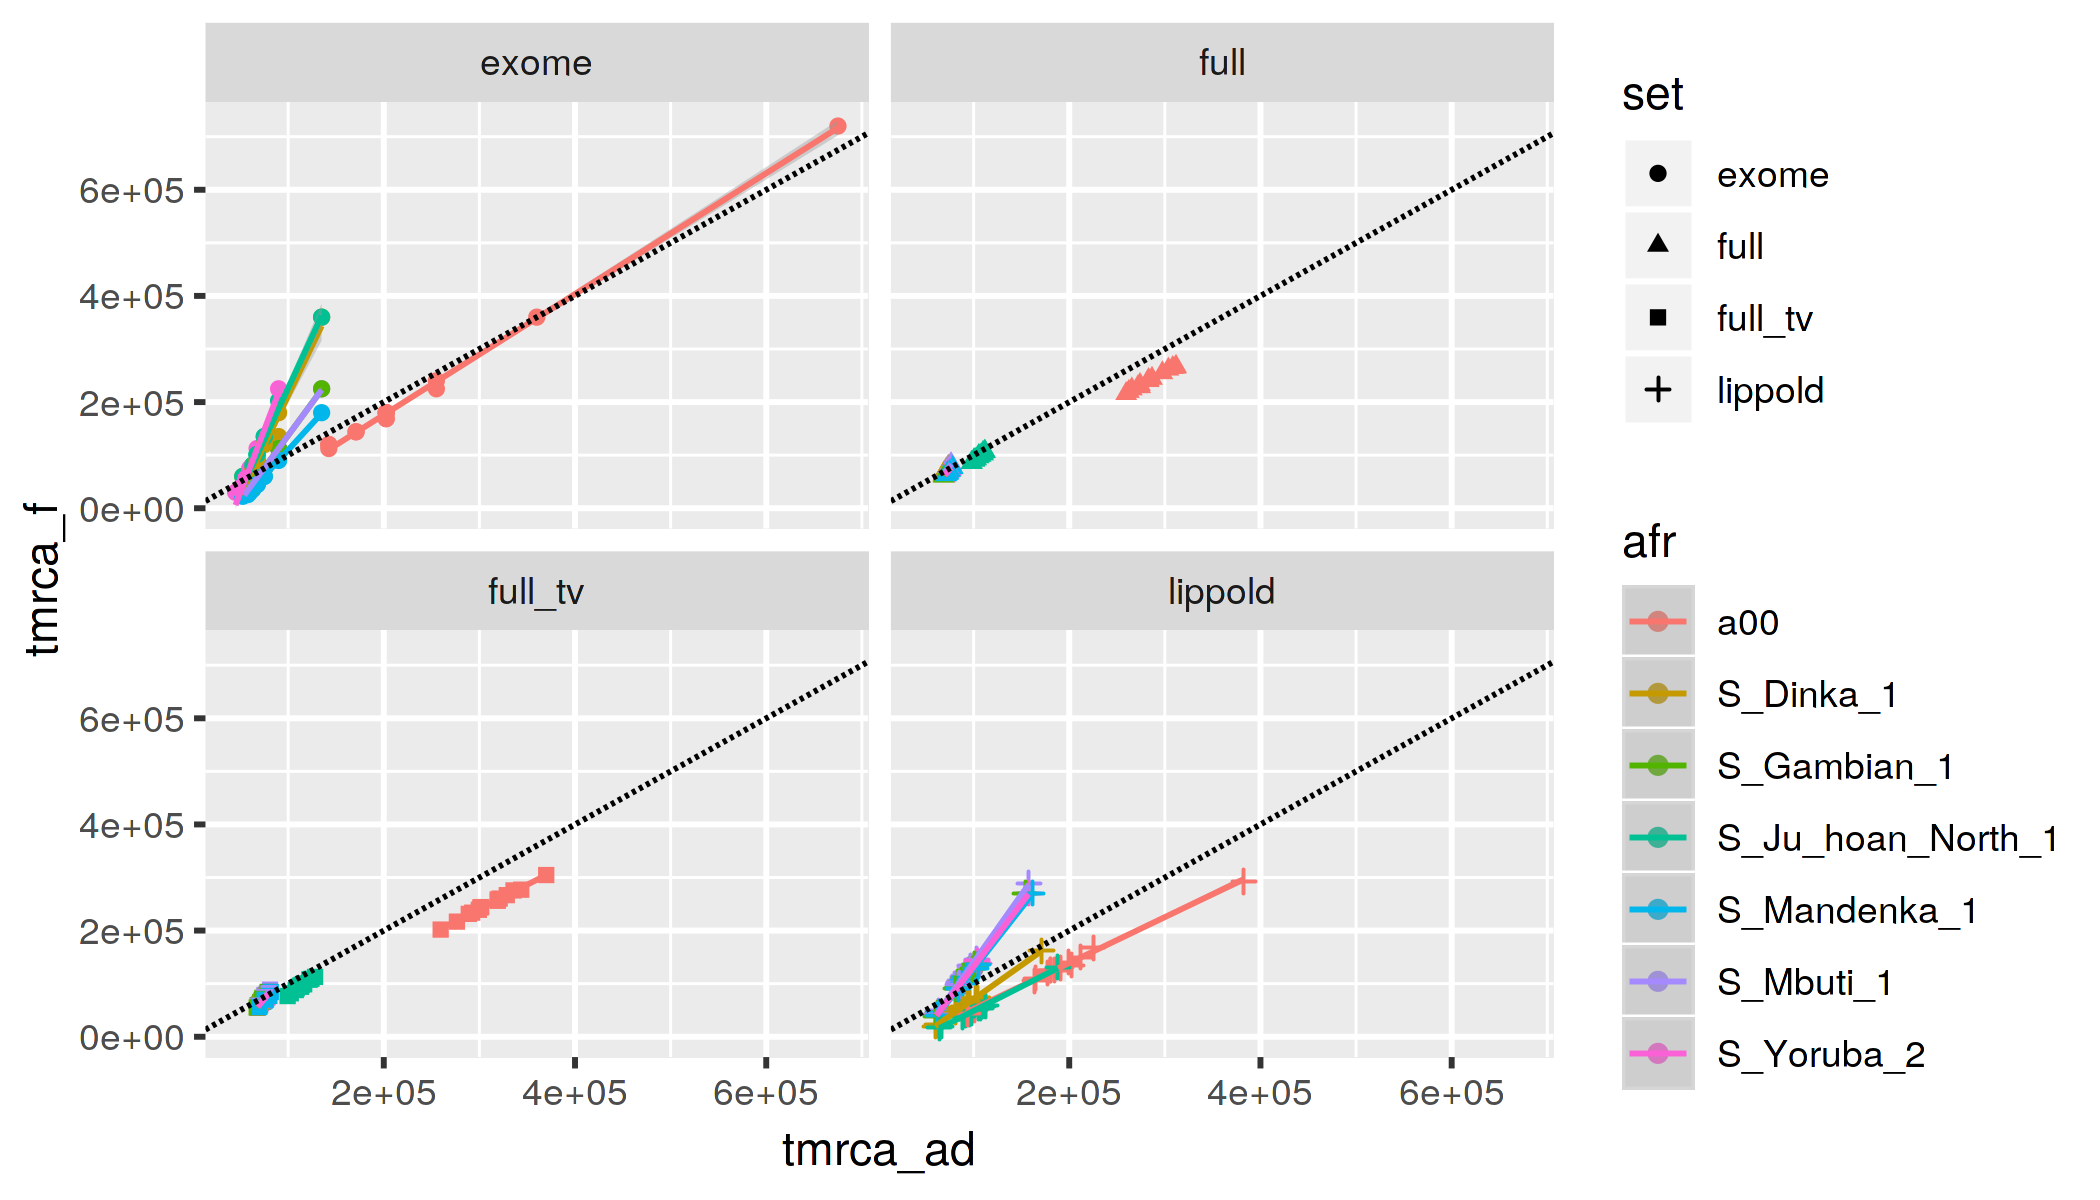

In [25]:
set_dim(7, 4)

filter(tarch, arch == "den8", !str_detect(set, "^x")) %>%
ggplot(aes(tmrca_ad, tmrca_f, color = afr, shape = set)) +
    geom_point() +
    geom_smooth(method = "lm", size = 0.5) +
    geom_abline(slope = 1, linetype = 2) +
    facet_wrap(~ set)